# INTRODUCTION


Pour atteindre l'objectif de ville neutre en émissions de carbone en 2050, la ville de Seattle s’intéresse de près aux émissions des bâtiments non destinés à l’habitation.

Des relevés minutieux ont été effectués en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, nous devons tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

Dans cette première partie, nous allons réaliser une courte analyse exploratoire après avoir nettoyé les données si besoin. Le but sera de déterminer les variables pertinentes ou d'en créer de nouvelles (feature engineering).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval 
plt.style.use('ggplot')
import seaborn as sns
sns.set_style("whitegrid")
sns.color_palette("crest", as_cmap=True)

#Lecture du dossier data Kaggle
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sea-building-energy-benchmarking/2016-building-energy-benchmarking.csv
/kaggle/input/sea-building-energy-benchmarking/socrata_metadata_2016-building-energy-benchmarking.json
/kaggle/input/sea-building-energy-benchmarking/2015-building-energy-benchmarking.csv
/kaggle/input/sea-building-energy-benchmarking/socrata_metadata_2015-building-energy-benchmarking.json


# SOMMAIRE

1. Environnement Python et Chargement des données 
  
  1.1. Comparaison des colonnes des datasets
 
  1.2. Uniformisation des données de localisation de 2015
 
  1.3. Description et nettoyage des données

  1.4. Les types de bâtiments
 
  1.5. Les années de construction
 
  2.Analyse exploratoire & Feature Engineering
  
  2.3. Les corrélations linéaires
 
  2.4. Analyse des variables à prédire

3.Dernières étapes de nettoyage

4.Projection des établissements sur la carte de Seattle

# 1. Environnement Python et Chargement des données

### Fonctions usuelles

In [2]:
def compare_colums(df1,df2):
    columns_1 = list(df1.columns) 
    columns_2 = list(df2.columns)
    same_columns=[]
    diff_columns_2=[]
    diff_columns_1=[]

    for col in columns_2:
        if col in columns_1:
            same_columns.append(col)
        else:
            diff_columns_2.append(col)
    for col in columns_1:
        if col not in columns_2:
            diff_columns_1.append(col)
    return diff_columns_1, diff_columns_2

In [3]:
data_2015 = pd.read_csv("../input/sea-building-energy-benchmarking/2015-building-energy-benchmarking.csv")
data_2016 = pd.read_csv("../input/sea-building-energy-benchmarking/2016-building-energy-benchmarking.csv")

In [4]:
data_2015.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,...,GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,...,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122...",7,DOWNTOWN,1996,...,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122...",7,DOWNTOWN,1969,...,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122...",7,DOWNTOWN,1926,...,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0,18081
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'latitude': '47.6137544', 'longitude': '-122....",7,DOWNTOWN,1980,...,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,19576


In [5]:
data_2016.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [6]:
diff_columns_2015, diff_columns_2016 = compare_colums(data_2015,data_2016)
diff_columns_2015

['Location',
 'OtherFuelUse(kBtu)',
 'GHGEmissions(MetricTonsCO2e)',
 'GHGEmissionsIntensity(kgCO2e/ft2)',
 'Comment',
 '2010 Census Tracts',
 'Seattle Police Department Micro Community Policing Plan Areas',
 'City Council Districts',
 'SPD Beats',
 'Zip Codes']

In [7]:
diff_columns_2015, diff_columns_2016 = compare_colums(data_2015,data_2016)
diff_columns_2016

['Address',
 'City',
 'State',
 'ZipCode',
 'Latitude',
 'Longitude',
 'Comments',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity']

### 1.2 Uniformisation des données de localisation de 2015

In [8]:
data_2015['Location'][0]

'{\'latitude\': \'47.61219025\', \'longitude\': \'-122.33799744\', \'human_address\': \'{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}\'}'

#### On remarque que les données de localisation pour le jeu de données de 2015 sont "compactées" dans une sorte de double dictionnaire. Nous allons donc travailler cette variable pour extraire chacune des variables imbriquées :

In [9]:
# Import ast
print(data_2015.shape)
data_2015= pd.concat([data_2015.drop(['Location'], axis=1),data_2015['Location']
                               .map(literal_eval).apply(pd.Series)],axis=1)
data_2015 = pd.concat([data_2015.drop(['human_address'], axis=1), data_2015['human_address']
                               .map(literal_eval).apply(pd.Series)], axis=1)
print(data_2015.shape)
                               

    

(3340, 47)
(3340, 52)


### On corrige le type de la latitude, longitude et le zipcode ainsi que la TaxParcelIdentificationNumber

In [10]:
data_2015["zip"] = pd.to_numeric(data_2015["zip"])
data_2015["latitude"] = pd.to_numeric(data_2015["latitude"])
data_2015["longitude"] = pd.to_numeric(data_2015["longitude"])



#### Nous avons à présent les colonnes correspondant à celles de 2016 : latitude, longitude, address, city, state et zip. Renommons les de la même façon :

In [11]:
data_2015 = data_2015.rename(columns={"latitude":"Latitude", "longitude":"Longitude",
                                      "address":"Address", "city":"City", 
                                      "state":"State", "zip":"ZipCode"})

### pour les  colonnes:

### 2015:

OtherFuelUse(kBtu): peu de données (17) dans la colonne => on la supprime

GHGEmissions(MetricTonsCO2e): correspond à la colonne TotalGHGEmissions du fichier 2016 => on renomme la colonne

GHGEmissionsIntensity(kgCO2e/ft2): correspond à la colonne GHGEmissionsIntensity du fichier 2016 => on renomme la colonne

Comment: colonne quasi vide, correspond à la colonne Comments du fichier 2016 mais inutile pour l'analyse => on la supprime
2010 Census Tracts: peu de donénes (17) dans la colonne => on la supprime

Seattle Police Department Micro Community Policing Plan Areas: colonne intéressantes qui pourraient être plus précise que le quartier pour le remplissage de nan par une moyenne pondérée sur la catégorie (exemple: secteur industriel) mais pas présente dans le fichier 2016, on la supprime mais on pourrait extrapoler les valeurs par l'adresse ou le numéro de building pour le fichier 2016

City Council Districts: peu de données (17) dans la colonne => on la supprime

SPD Beats: idem que le Seattle Police Department Micro Community Policing Plan Areas en moins précis, on supprime

Zip Codes: cette colonne contient des valeurs qui ne sont pas cohérentes => suppression

### 2016:

Comments: colonne vide, correspond à la colonne Comment du fichier 2015 inutile pour l'analyse => on la supprime

TotalGHGEmissions : correspond à la colonne TotalGHGEmissions du fichier 2015 qu'on va renommer

GHGEmissionsIntensity: correspond à la colonne GHGEmissionsIntensity du fichier 2015 qu'on va renommer

to_drop = ['OtherFuelUse(kBtu)','Comment','2010 Census Tracts','Seattle Police Department Micro Community Policing Plan Areas','City Council Districts', 'SPD Beats', 'Zip Codes']


#### Eliminons maintenant les colonnes de 2015 n'ayant pas d'equivalents en 2016

In [12]:
data_2015=data_2015.drop(['OtherFuelUse(kBtu)','2010 Census Tracts',
                'Seattle Police Department Micro Community Policing Plan Areas',
                'City Council Districts','SPD Beats', 'Zip Codes'], axis=1)

#### Renommons les trois colonnes de 2015 qui restent ainsi que de 2016 a l'identique

In [13]:
data_2015 = data_2015.rename(columns={'GHGEmissions(MetricTonsCO2e)':'TotalGHGEmissions',
                                     'GHGEmissionsIntensity(kgCO2e/ft2)':'GHGEmissionsIntensity',
                                     'Comment':'Comments'})

In [14]:
data_2015 = data_2015.drop(['Comments'], axis=1)
data_2016 = data_2016.drop(['Comments'], axis=1)

#### Comparons de nouveau

In [15]:
diff_columns_2015, diff_columns_2016 = compare_colums(data_2015,data_2016)
print(diff_columns_2015,diff_columns_2016)

[] []


#### Les variables des 2 datasets étant à présent identiques, nous allons pouvoir les regrouper en un unique jeu de données :

In [16]:
data = pd.concat([data_2015[data_2016.columns],data_2016], axis = 0).sort_values(["DataYear", "OSEBuildingID"])
data.shape

(6716, 45)

### 1.3. Description et nettoyage des données

In [17]:
# check le pourcentage de remplissage des colonnes
columns_nan_info ={}
for column in data.keys():
    nan_count = data[column].isnull().sum()
    columns_nan_info[column] = nan_count / data.shape[0] * 100

df_columns_nan_info = pd.DataFrame(data=np.array(list(columns_nan_info.items())),columns=['column','nan %'])
df_columns_nan_info['nan %'] = pd.to_numeric(df_columns_nan_info['nan %'])
df_columns_nan_info = df_columns_nan_info.sort_values(by=['nan %'])

print(df_columns_nan_info.shape)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(df_columns_nan_info)

(45, 2)
                             column      nan %
0                     OSEBuildingID   0.000000
19           PropertyGFABuilding(s)   0.000000
41                 ComplianceStatus   0.000000
14                        YearBuilt   0.000000
13                        Longitude   0.000000
12                         Latitude   0.000000
11                     Neighborhood   0.000000
10              CouncilDistrictCode   0.000000
17                 PropertyGFATotal   0.000000
18               PropertyGFAParking   0.000000
7                             State   0.000000
6                              City   0.000000
5                           Address   0.000000
4                      PropertyName   0.000000
3               PrimaryPropertyType   0.000000
2                      BuildingType   0.000000
1                          DataYear   0.000000
40                      DefaultData   0.014890
9     TaxParcelIdentificationNumber   0.029780
15                NumberofBuildings   0.119119
16   

#### On peut commencer par supprimer les lignes répertoriées comme des outliers avant de supprimer la colonne. On peut aussi supprimer la colonne YearsENERGYSTARCertified qui est très peu remplie et qui ne parait pas d'une grande utilité. Pour les usages secondaires et tertiaires des batiments les codes non renseignées doivent correspondre à aucun usage, on conservera donc ces données qui pourraient fortement influer les analyses sur la consommation énergétique.

In [18]:
data = data[data['Outlier'].isnull()] 
data = data.drop(['Outlier', 'YearsENERGYSTARCertified'], axis=1)
display(data.shape)

(6600, 43)

In [19]:
lines_nan_info=[]
for index,row in data.iterrows(): 
    lines_nan_info.append( (1- row.isna().sum().sum()/data.shape[1])*100)
data_lines_nan_info = pd.DataFrame(np.array(lines_nan_info),columns=['nan %'])
print(data_lines_nan_info.sort_values(by=['nan %']))

           nan %
5708   48.837209
5032   48.837209
3825   48.837209
5903   48.837209
4008   48.837209
...          ...
5550  100.000000
1535  100.000000
819   100.000000
253   100.000000
4652  100.000000

[6600 rows x 1 columns]


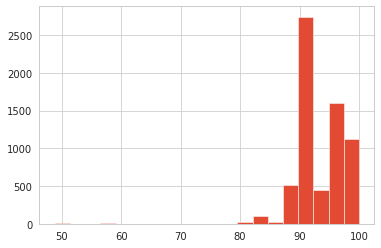

(6454, 1)
97.78787878787878


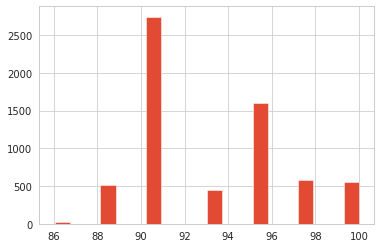

In [20]:
data_lines_nan_info['nan %'].hist(bins=20)
plt.show()

# calcul du pourcentage de données qu'on garde en filtrant les lignes par un certains pourcentage de valeurs nan
data_filtered_lines_nan_score =data_lines_nan_info[data_lines_nan_info['nan %']>86]
print(data_filtered_lines_nan_score.shape)
print(100*data_filtered_lines_nan_score.shape[0]/data.shape[0])
data_filtered_lines_nan_score['nan %'].hist(bins=20)
plt.show()

#### En gardant les lignes remplies à au moins 86%, on conserverait un plus de 97% des données totales et ce serait les données les plus qualitatives, je vais donc faire ce choix.

In [21]:
filled_rate = 86/100
filtered_rows=[]
data = data[data.count(axis='columns')/data.shape[1]>filled_rate].reset_index(drop=True)
print(data.shape)
display(data)

(6454, 43)


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,405 OLIVE WAY,SEATTLE,WA,98101.0,659000030,...,7.097539e+06,2023032.0,1.080307e+06,3.686160e+06,12724.000000,1.272388e+06,No,Compliant,249.43,2.64
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,724 PINE ST,SEATTLE,WA,98101.0,659000220,...,8.765788e+06,0.0,1.144563e+06,3.905411e+06,44490.000000,4.448985e+06,No,Compliant,263.51,2.38
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,1900 5TH AVE,SEATTLE,WA,98101.0,659000475,...,7.550627e+07,19660404.0,1.458393e+07,4.976244e+07,37099.000000,3.709900e+06,Yes,Compliant,2061.48,1.92
3,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,401 LENORA ST,SEATTLE,WA,98121.0,659000970,...,1.507824e+07,0.0,1.777841e+06,6.066245e+06,87631.000000,8.763105e+06,No,Compliant,507.70,4.02
4,9,2015,Nonresidential COS,Other,WEST PRECINCT (SEATTLE POLICE),810 VIRGINIA ST,SEATTLE,WA,98101.0,660000560,...,1.304526e+07,0.0,2.130921e+06,7.271004e+06,47813.000000,4.781283e+06,No,Compliant,304.62,2.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6449,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,...,9.430032e+05,0.0,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,True,Error - Correct Default Data,20.94,1.70
6450,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,...,1.053706e+06,0.0,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,False,Compliant,32.17,2.01
6451,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,...,6.053764e+06,0.0,5.252517e+05,1.792159e+06,39737.390630,3.973739e+06,False,Compliant,223.54,16.99
6452,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Center,8319 8th Ave S,Seattle,WA,NaN,7883603155,...,7.828413e+05,0.0,1.022480e+05,3.488702e+05,3706.010010,3.706010e+05,False,Compliant,22.11,1.57


#### Eliminons aussi les valeurs negatives des valeurs quatitatives

In [22]:
# contrôle des valeurs negatives
quantitative_columns = ['PropertyGFATotal', 'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)',
                        'SiteEUI(kBtu/sf)', 'TotalGHGEmissions', 'GHGEmissionsIntensity']
for column in quantitative_columns:
    incoherent_values = data[data[column] <=0]
    if(incoherent_values.shape[0]>0):
        print(column)
        display(incoherent_values)
        data.drop(incoherent_values.index)

SourceEUI(kBtu/sf)


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
39,58,2015,NonResidential,Retail Store,CENTURY SQUARE RETAIL,1525 4TH AVE,SEATTLE,WA,98101.0,1975700365,...,0.000000e+00,0.0,0.000000e+00,0.0,0.000000,0.0,No,Compliant,0.00,0.00
537,765,2015,NonResidential,Large Office,SEATTLE TOWER,1218 3RD AVE,SEATTLE,WA,98101.0,1975200005,...,0.000000e+00,0.0,0.000000e+00,0.0,0.000000,0.0,No,Compliant,0.00,0.00
3151,34,2016,SPS-District K-12,K-12 School,Meany Building,301/300 21st Ave. E.,Seattle,WA,98112.0,0688000090,...,0.000000e+00,0.0,0.000000e+00,0.0,0.000000,0.0,False,Missing Data,0.00,0.00
3154,37,2016,SPS-District K-12,K-12 School,John Hay Elementary,201 Garfield St.,Seattle,WA,98109.0,0809000005,...,0.000000e+00,0.0,4.386917e+05,1496816.0,0.000000,0.0,False,Missing Data,10.43,0.20
3185,87,2016,SPS-District K-12,K-12 School,Arbor Heights Elementary,3701 S.W. 104th St.,Seattle,WA,98146.0,2518400005,...,0.000000e+00,0.0,1.760881e+05,600813.0,0.000000,0.0,False,Missing Data,4.19,0.08
3204,118,2016,SPS-District K-12,K-12 School,Pathfinder K-8,1901 SW Genesee St.,Seattle,WA,98106.0,1324039116,...,0.000000e+00,0.0,4.977068e+05,1698176.0,0.000000,0.0,False,Missing Data,11.84,0.16
3208,122,2016,SPS-District K-12,K-12 School,John Muir Elementary,3301 S. Horton St.,Seattle,WA,98144.0,1524049002,...,0.000000e+00,0.0,6.879069e+05,2347138.0,0.000000,0.0,False,Missing Data,16.36,0.28
3218,140,2016,SPS-District K-12,K-12 School,B.F. Day Elementary,3921 Linden Ave. N.,Seattle,WA,98103.0,1931301145,...,0.000000e+00,0.0,6.167308e+05,2104286.0,0.000000,0.0,False,Missing Data,14.67,0.22
3255,217,2016,SPS-District K-12,K-12 School,Whitman Middle,9201 15th Ave. NW.,Seattle,WA,98117.0,3526039131,...,0.000000e+00,0.0,0.000000e+00,0.0,43189.171880,4318917.0,False,Missing Data,229.38,1.43
3261,227,2016,SPS-District K-12,K-12 School,Washington Middle,2101 S. Jackson,Seattle,WA,98144.0,3646100540,...,0.000000e+00,0.0,0.000000e+00,0.0,32178.773440,3217877.0,False,Missing Data,170.90,1.25


SiteEnergyUse(kBtu)


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
39,58,2015,NonResidential,Retail Store,CENTURY SQUARE RETAIL,1525 4TH AVE,SEATTLE,WA,98101.0,1975700365,...,0.0,0.0,0.0000,0.0,0.000000,0.0,No,Compliant,0.00,0.00
537,765,2015,NonResidential,Large Office,SEATTLE TOWER,1218 3RD AVE,SEATTLE,WA,98101.0,1975200005,...,0.0,0.0,0.0000,0.0,0.000000,0.0,No,Compliant,0.00,0.00
3151,34,2016,SPS-District K-12,K-12 School,Meany Building,301/300 21st Ave. E.,Seattle,WA,98112.0,0688000090,...,0.0,0.0,0.0000,0.0,0.000000,0.0,False,Missing Data,0.00,0.00
3154,37,2016,SPS-District K-12,K-12 School,John Hay Elementary,201 Garfield St.,Seattle,WA,98109.0,0809000005,...,0.0,0.0,438691.6875,1496816.0,0.000000,0.0,False,Missing Data,10.43,0.20
3185,87,2016,SPS-District K-12,K-12 School,Arbor Heights Elementary,3701 S.W. 104th St.,Seattle,WA,98146.0,2518400005,...,0.0,0.0,176088.0938,600813.0,0.000000,0.0,False,Missing Data,4.19,0.08
3204,118,2016,SPS-District K-12,K-12 School,Pathfinder K-8,1901 SW Genesee St.,Seattle,WA,98106.0,1324039116,...,0.0,0.0,497706.8125,1698176.0,0.000000,0.0,False,Missing Data,11.84,0.16
3208,122,2016,SPS-District K-12,K-12 School,John Muir Elementary,3301 S. Horton St.,Seattle,WA,98144.0,1524049002,...,0.0,0.0,687906.8750,2347138.0,0.000000,0.0,False,Missing Data,16.36,0.28
3218,140,2016,SPS-District K-12,K-12 School,B.F. Day Elementary,3921 Linden Ave. N.,Seattle,WA,98103.0,1931301145,...,0.0,0.0,616730.8125,2104286.0,0.000000,0.0,False,Missing Data,14.67,0.22
3255,217,2016,SPS-District K-12,K-12 School,Whitman Middle,9201 15th Ave. NW.,Seattle,WA,98117.0,3526039131,...,0.0,0.0,0.0000,0.0,43189.171880,4318917.0,False,Missing Data,229.38,1.43
3261,227,2016,SPS-District K-12,K-12 School,Washington Middle,2101 S. Jackson,Seattle,WA,98144.0,3646100540,...,0.0,0.0,0.0000,0.0,32178.773440,3217877.0,False,Missing Data,170.90,1.25


SiteEUI(kBtu/sf)


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
39,58,2015,NonResidential,Retail Store,CENTURY SQUARE RETAIL,1525 4TH AVE,SEATTLE,WA,98101.0,1975700365,...,0.0,0.0,0.0000,0.0,0.000000,0.0,No,Compliant,0.00,0.00
537,765,2015,NonResidential,Large Office,SEATTLE TOWER,1218 3RD AVE,SEATTLE,WA,98101.0,1975200005,...,0.0,0.0,0.0000,0.0,0.000000,0.0,No,Compliant,0.00,0.00
3151,34,2016,SPS-District K-12,K-12 School,Meany Building,301/300 21st Ave. E.,Seattle,WA,98112.0,0688000090,...,0.0,0.0,0.0000,0.0,0.000000,0.0,False,Missing Data,0.00,0.00
3154,37,2016,SPS-District K-12,K-12 School,John Hay Elementary,201 Garfield St.,Seattle,WA,98109.0,0809000005,...,0.0,0.0,438691.6875,1496816.0,0.000000,0.0,False,Missing Data,10.43,0.20
3185,87,2016,SPS-District K-12,K-12 School,Arbor Heights Elementary,3701 S.W. 104th St.,Seattle,WA,98146.0,2518400005,...,0.0,0.0,176088.0938,600813.0,0.000000,0.0,False,Missing Data,4.19,0.08
3204,118,2016,SPS-District K-12,K-12 School,Pathfinder K-8,1901 SW Genesee St.,Seattle,WA,98106.0,1324039116,...,0.0,0.0,497706.8125,1698176.0,0.000000,0.0,False,Missing Data,11.84,0.16
3208,122,2016,SPS-District K-12,K-12 School,John Muir Elementary,3301 S. Horton St.,Seattle,WA,98144.0,1524049002,...,0.0,0.0,687906.8750,2347138.0,0.000000,0.0,False,Missing Data,16.36,0.28
3218,140,2016,SPS-District K-12,K-12 School,B.F. Day Elementary,3921 Linden Ave. N.,Seattle,WA,98103.0,1931301145,...,0.0,0.0,616730.8125,2104286.0,0.000000,0.0,False,Missing Data,14.67,0.22
3255,217,2016,SPS-District K-12,K-12 School,Whitman Middle,9201 15th Ave. NW.,Seattle,WA,98117.0,3526039131,...,0.0,0.0,0.0000,0.0,43189.171880,4318917.0,False,Missing Data,229.38,1.43
3261,227,2016,SPS-District K-12,K-12 School,Washington Middle,2101 S. Jackson,Seattle,WA,98144.0,3646100540,...,0.0,0.0,0.0000,0.0,32178.773440,3217877.0,False,Missing Data,170.90,1.25


TotalGHGEmissions


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
39,58,2015,NonResidential,Retail Store,CENTURY SQUARE RETAIL,1525 4TH AVE,SEATTLE,WA,98101.0,1975700365,...,0.000000e+00,0.0,0.00000,0.0,0.0,0.0,No,Compliant,0.0,0.00
537,765,2015,NonResidential,Large Office,SEATTLE TOWER,1218 3RD AVE,SEATTLE,WA,98101.0,1975200005,...,0.000000e+00,0.0,0.00000,0.0,0.0,0.0,No,Compliant,0.0,0.00
3151,34,2016,SPS-District K-12,K-12 School,Meany Building,301/300 21st Ave. E.,Seattle,WA,98112.0,0688000090,...,0.000000e+00,0.0,0.00000,0.0,0.0,0.0,False,Missing Data,0.0,0.00
3274,242,2016,SPS-District K-12,K-12 School,Olympic View Elementary,504 N.E. 95th St.,Seattle,WA,98115.0,5100404840,...,0.000000e+00,0.0,0.00000,0.0,0.0,0.0,False,Missing Data,0.0,0.00
3426,435,2016,NonResidential,Other,Washington State Convention Center,705 Pike St,Seattle,WA,98101.0,1978200105,...,0.000000e+00,0.0,0.00000,0.0,0.0,0.0,False,Non-Compliant,0.0,0.00
3629,700,2016,NonResidential,Supermarket / Grocery Store,IUC- Whole Foods Interbay,2001 15th Avenue West,Seattle,WA,98119.0,7666201460,...,1.284386e+07,0.0,0.00000,0.0,0.0,0.0,False,Compliant,0.0,0.00
3861,19776,2016,NonResidential,Other,Welcome Home Society - PriceCo,13537 Aurora Ave N,Seattle,WA,98133.0,0164000020,...,0.000000e+00,0.0,0.00000,0.0,0.0,0.0,False,Missing Data,0.0,0.00
3874,19801,2016,Multifamily LR (1-4),Other,APEX BELLTOWN COOP,2225 First Ave,Seattle,WA,98121.0,0246300000,...,0.000000e+00,0.0,0.00000,0.0,0.0,0.0,False,Missing Data,0.0,0.00
4429,21524,2016,Multifamily LR (1-4),Low-Rise Multifamily,Minor Tower Apartments,2525 Minor Ave E,Seattle,WA,98102.0,2025049091,...,9.197677e+05,0.0,0.00000,0.0,0.0,0.0,False,Compliant,0.0,0.00
4466,21616,2016,SPS-District K-12,K-12 School,Olympic Hills Elementary,13018 20th Ave. N.E.,Seattle,WA,98125.0,2126049041,...,0.000000e+00,0.0,0.00000,0.0,0.0,0.0,True,Error - Correct Default Data,0.0,0.00


GHGEmissionsIntensity


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
39,58,2015,NonResidential,Retail Store,CENTURY SQUARE RETAIL,1525 4TH AVE,SEATTLE,WA,98101.0,1975700365,...,0.000000e+00,0.0,0.00000,0.0,0.0,0.0,No,Compliant,0.00,0.00
537,765,2015,NonResidential,Large Office,SEATTLE TOWER,1218 3RD AVE,SEATTLE,WA,98101.0,1975200005,...,0.000000e+00,0.0,0.00000,0.0,0.0,0.0,No,Compliant,0.00,0.00
1227,21474,2015,NonResidential,Other,SULTAN HOTEL/LUSTY LADY,1315 1ST AVE,SEATTLE,WA,98101.0,1976200060,...,2.412600e+04,0.0,7071.00000,24127.0,0.0,0.0,No,Compliant,0.17,0.00
1492,22548,2015,NonResidential,Self-Storage Facility\n,SELF STORAGE MINI WAREHOUSE,2648 15TH AVE W,SEATTLE,WA,98119.0,2770603955,...,5.511300e+04,0.0,15651.00000,53404.0,0.0,0.0,No,Compliant,0.37,0.00
1793,23730,2015,NonResidential,Non-Refrigerated Warehouse,SALMON BAY TERMINALS - RSVP BLDG,4021 13TH AVE W,SEATTLE,WA,98119.0,7666200120,...,1.144100e+04,0.0,3353.00000,11442.0,0.0,0.0,No,Compliant,0.08,0.00
2078,24717,2015,NonResidential,Other,1701 1ST AVE S,1701 1ST AVE S,SEATTLE,WA,98134.0,7666207085,...,1.715000e+04,0.0,5026.00000,17150.0,0.0,0.0,No,Compliant,0.12,0.00
3151,34,2016,SPS-District K-12,K-12 School,Meany Building,301/300 21st Ave. E.,Seattle,WA,98112.0,0688000090,...,0.000000e+00,0.0,0.00000,0.0,0.0,0.0,False,Missing Data,0.00,0.00
3274,242,2016,SPS-District K-12,K-12 School,Olympic View Elementary,504 N.E. 95th St.,Seattle,WA,98115.0,5100404840,...,0.000000e+00,0.0,0.00000,0.0,0.0,0.0,False,Missing Data,0.00,0.00
3426,435,2016,NonResidential,Other,Washington State Convention Center,705 Pike St,Seattle,WA,98101.0,1978200105,...,0.000000e+00,0.0,0.00000,0.0,0.0,0.0,False,Non-Compliant,0.00,0.00
3629,700,2016,NonResidential,Supermarket / Grocery Store,IUC- Whole Foods Interbay,2001 15th Avenue West,Seattle,WA,98119.0,7666201460,...,1.284386e+07,0.0,0.00000,0.0,0.0,0.0,False,Compliant,0.00,0.00


### 1.4. Le type de batiments à choisir(public)

#### Il est précisié dans le projet que seuls les bâtiments non destinés à l'habitation seront étudiés. Nous allons donc supprimer toutes les lignes correspondant à des habitations en nous basant sur la variable BuildingType

In [23]:
data['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Multifamily LR (1-4)', 'Campus',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [24]:
building_types = sorted(data['BuildingType'].unique())
primary_property_types = sorted(data['PrimaryPropertyType'].unique())
display(building_types)
display(len(building_types))
display(primary_property_types)
display(len(primary_property_types))

['Campus',
 'Multifamily HR (10+)',
 'Multifamily LR (1-4)',
 'Multifamily MR (5-9)',
 'NonResidential',
 'Nonresidential COS',
 'Nonresidential WA',
 'SPS-District K-12']

8

['College/University',
 'Distribution Center',
 'Distribution Center\n',
 'High-Rise Multifamily',
 'Hospital',
 'Hotel',
 'K-12 School',
 'Laboratory',
 'Large Office',
 'Low-Rise Multifamily',
 'Medical Office',
 'Mid-Rise Multifamily',
 'Mixed Use Property',
 'Non-Refrigerated Warehouse',
 'Office',
 'Other',
 'Refrigerated Warehouse',
 'Residence Hall',
 'Residence Hall/Dormitory',
 'Restaurant',
 'Restaurant\n',
 'Retail Store',
 'Self-Storage Facility',
 'Self-Storage Facility\n',
 'Senior Care Community',
 'Small- and Mid-Sized Office',
 'Supermarket / Grocery Store',
 'Supermarket/Grocery Store',
 'University',
 'Warehouse',
 'Worship Facility']

31

#### Il y a des doublons avec des sauts de lignes et des espaces, on va les supprimer:

In [25]:
import re
data['PrimaryPropertyType'] = [re.compile(r'[\n\r\t]').sub("", item) for index, item in data.PrimaryPropertyType.iteritems()]
data['PrimaryPropertyType'] = [re.compile(r' / ').sub("/", item) for index, item in data.PrimaryPropertyType.iteritems()]

In [26]:
building_types = sorted(data['BuildingType'].unique())
primary_property_types = sorted(data['PrimaryPropertyType'].unique())
display(building_types)
display(len(building_types))
display(primary_property_types)
display(len(primary_property_types))

['Campus',
 'Multifamily HR (10+)',
 'Multifamily LR (1-4)',
 'Multifamily MR (5-9)',
 'NonResidential',
 'Nonresidential COS',
 'Nonresidential WA',
 'SPS-District K-12']

8

['College/University',
 'Distribution Center',
 'High-Rise Multifamily',
 'Hospital',
 'Hotel',
 'K-12 School',
 'Laboratory',
 'Large Office',
 'Low-Rise Multifamily',
 'Medical Office',
 'Mid-Rise Multifamily',
 'Mixed Use Property',
 'Non-Refrigerated Warehouse',
 'Office',
 'Other',
 'Refrigerated Warehouse',
 'Residence Hall',
 'Residence Hall/Dormitory',
 'Restaurant',
 'Retail Store',
 'Self-Storage Facility',
 'Senior Care Community',
 'Small- and Mid-Sized Office',
 'Supermarket/Grocery Store',
 'University',
 'Warehouse',
 'Worship Facility']

27

In [27]:
from IPython.core.display import HTML
building_types_and_usages = {}
for building_type in building_types:
    temp = data[data['BuildingType']==building_type]['PrimaryPropertyType'].unique()
    building_types_and_usages[building_type]=temp.tolist()

display(HTML('<br />'))

i=0
for group,subgroups in building_types_and_usages.items():
    text = "<strong>" + group + ": </strong>"
    for subgroup in subgroups:
        text += subgroup + ", "
        i = i +1
    display(HTML(text+'<br />'))
    
display(HTML('<br />'))

print('Il y a {} groupe/sous-catégories et {} catégories uniques'.format(i,len(primary_property_types))) 

Il y a 60 groupe/sous-catégories et 27 catégories uniques


#### Les types d'usages des bâtiments ne sont donc pas sous-catégories uniqes des types de bâtiments. De plus on retrouve un usage de type "Low-Rise Multifamily" dans le type "NonResidential", analysons en détail ce type d'anomalie.

In [28]:
data_anomalies = data[~data['BuildingType'].str.contains("Multifamily") & data['PrimaryPropertyType'].str.contains("Multifamily")]
display(data_anomalies)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
1232,21481,2015,Campus,Low-Rise Multifamily,SANITARY MARKET - MASTER CAMPUS FOR PIKE PLACE...,1513 1ST AVE,SEATTLE,WA,98101.0,1976200210,...,3863772.000,0.0,1.132407e+06,3863933.0,0.000000,0.0,No,Compliant,26.94,0.23
2324,25674,2015,NonResidential,Low-Rise Multifamily,COMET TAVERN,916 E PIKE ST,SEATTLE,WA,98122.0,6003500480,...,93851.000,0.0,1.929000e+03,6581.0,873.000000,87270.0,No,Compliant,4.68,0.14
3758,19445,2016,NonResidential,Low-Rise Multifamily,Pacific Pointe,2108 N Pacific St.,Seattle,WA,98103.0,0354000254,...,2090011.625,0.0,5.111956e+05,1744199.0,2529.819824,252982.0,False,Compliant,25.60,0.28
4406,21481,2016,Campus,Low-Rise Multifamily,Sanitary Market,1525 FIrst Avenue,Seattle,WA,98101.0,1976200210,...,3778355.000,0.0,1.107372e+06,3778355.0,0.000000,0.0,False,Compliant,26.34,0.58


#### Vu le nombre de lignes concernées il s'agit bien d'anomalies dont on ne tiendra pas compte. Pour supprimer les lignes concernant les usages résidentielles nous supprimerons donc les lignes contenant le terme "Multifamily" dans le type de bâtiment ou dans son type d'usage.

In [29]:
data= data[~data['BuildingType'].str.contains("Multifamily") & ~data['PrimaryPropertyType'].str.contains("Multifamily")]
display(data.shape)

(3194, 43)

In [30]:
data['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus', 'Nonresidential WA'], dtype=object)

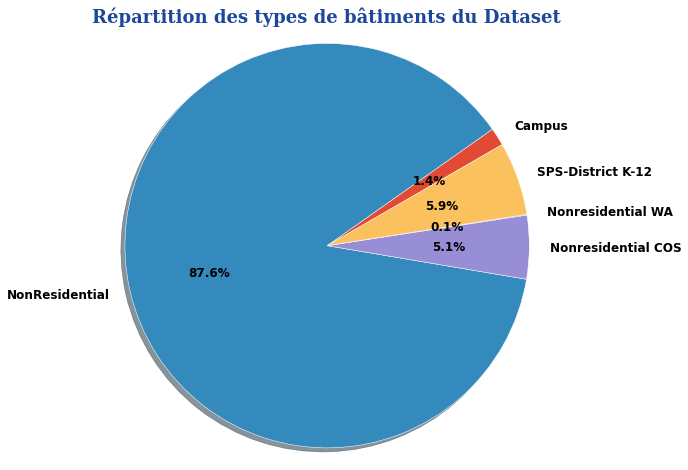

In [31]:
building_type = data.groupby(by='BuildingType')['OSEBuildingID'].nunique()

font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }

fig, ax = plt.subplots(figsize=(8,8))
ax.pie(building_type.values, labels=building_type.index, 
       autopct='%1.1f%%', shadow=True, startangle=30,
       textprops=dict(color="black",size=12, weight="bold"))
ax.axis('equal')
ax.set_title("Répartition des types de bâtiments du Dataset", fontdict=font_title)
plt.show()

la majeur partie des bâtiments sont typés "NonResidential". Nous pouvons visualiser les diverses catégories représentées dans ce type de bâtiments :

In [32]:
data.loc[(data['BuildingType']=="NonResidential"),'PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    551
Other                          375
Large Office                   316
Mixed Use Property             195
Warehouse                      180
Retail Store                   176
Non-Refrigerated Warehouse     176
Hotel                          140
Worship Facility               139
Distribution Center            100
Medical Office                  79
K-12 School                     77
Supermarket/Grocery Store       75
Self-Storage Facility           54
Senior Care Community           39
Refrigerated Warehouse          24
Residence Hall                  21
Restaurant                      19
Hospital                        19
University                      17
Residence Hall/Dormitory        15
College/University              15
Laboratory                      10
Name: PrimaryPropertyType, dtype: int64

### 1.5. Les années de construction

Text(0.5, 1.0, 'Distribution des années de construction des bâtiments\n')

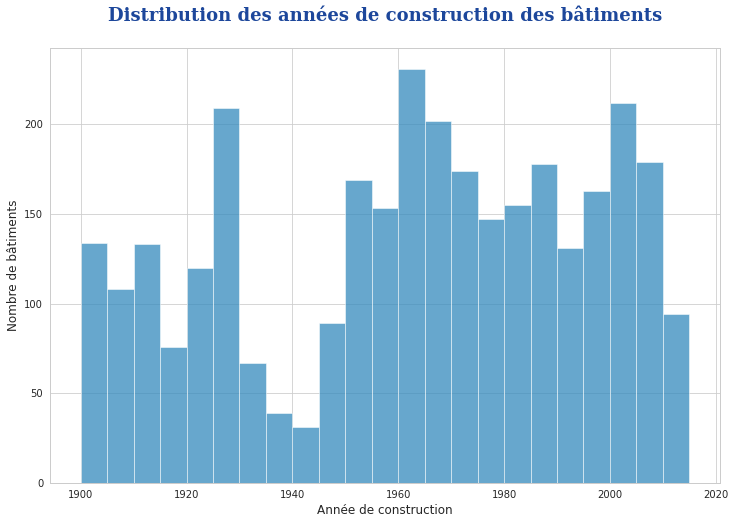

In [33]:
fig = plt.figure(figsize=(12,8))
ax = sns.histplot(data=data, x='YearBuilt', bins=int((data.YearBuilt.max() - data.YearBuilt.min())/5))
ax.set_xlabel("Année de construction")
ax.set_ylabel("Nombre de bâtiments")
plt.title(f"Distribution des années de construction des bâtiments\n", fontdict=font_title)

#### Plus que l'année de construction, il serait intéressant de traiter l'age des bâtiments pour réduire la dispersion des données et lier l'année des relevés. Nous allons donc créer cette nouvelle variable et supprimer l'année de construction :

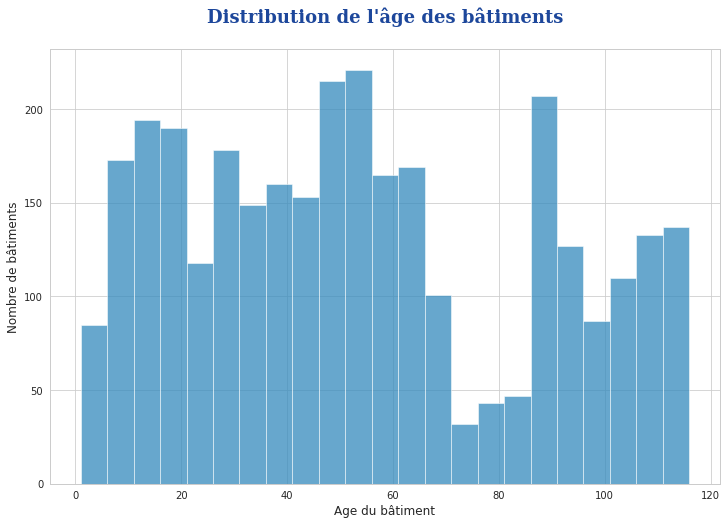

In [34]:
data['BuildingAge'] = data['DataYear'] - data['YearBuilt']
fig = plt.figure(figsize=(12,8))
ax = sns.histplot(data=data, x='BuildingAge', bins=int((data.BuildingAge.max() - data.BuildingAge.min())/5))
ax.set_xlabel("Age du bâtiment")
ax.set_ylabel("Nombre de bâtiments")
plt.title(f"Distribution de l'âge des bâtiments\n", fontdict=font_title)
plt.show()

#### Verifions maintenant le remplissge des colonnes

In [35]:
# on check le pourcentage de remplissage des colonnes
columns_nan_info ={}
for column in data.keys():
    nan_count = data[column].isnull().sum()
    columns_nan_info[column] = nan_count / data.shape[0] * 100

df_columns_nan_info = pd.DataFrame(data=np.array(list(columns_nan_info.items())),columns=['column','nan %'])
df_columns_nan_info['nan %'] = pd.to_numeric(df_columns_nan_info['nan %'])
df_columns_nan_info = df_columns_nan_info.sort_values(by=['nan %'])

print(df_columns_nan_info.shape)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(df_columns_nan_info)

(44, 2)
                             column      nan %
0                     OSEBuildingID   0.000000
19           PropertyGFABuilding(s)   0.000000
20        ListOfAllPropertyUseTypes   0.000000
42            GHGEmissionsIntensity   0.000000
30               SourceEUI(kBtu/sf)   0.000000
31             SourceEUIWN(kBtu/sf)   0.000000
32              SiteEnergyUse(kBtu)   0.000000
18               PropertyGFAParking   0.000000
34                   SteamUse(kBtu)   0.000000
36                Electricity(kBtu)   0.000000
37               NaturalGas(therms)   0.000000
38                 NaturalGas(kBtu)   0.000000
39                      DefaultData   0.000000
40                 ComplianceStatus   0.000000
41                TotalGHGEmissions   0.000000
35                 Electricity(kWh)   0.000000
17                 PropertyGFATotal   0.000000
43                      BuildingAge   0.000000
15                NumberofBuildings   0.000000
1                          DataYear   0.000000
2    

#### On perdra très peu de données en supprimant les lignes contenant des valeurs inconnues pour les colonnes SiteEnergyUseWN(kBtu), SiteEUIWN(kBtu/sf), SiteEUI(kBtu/sf), NumberofFloors, ZipCode donc faisons le.

In [36]:
data = data.dropna(subset = ['SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)', 'SiteEUI(kBtu/sf)', 'NumberofFloors', 'ZipCode' ,
                             'LargestPropertyUseTypeGFA','LargestPropertyUseType'])
print(data.shape)

(3164, 44)


#### Vocabulaire


Maintenant que nous avons dégrossis et affiner le jeu de données, détaillons un peu les acronymes utilisés dans les colonnes:

GHG: greenhouse gas emissions, correspond aux émissions des gazs à effet de serre.

OSE: Seattle Office of Sustainability and Environment.

EUI: Energy Use Intensity.

kBtu: kilo-British thermal unit, 1 kWh = 3.412 kBtu.

sf: square feet, 1m² = 10,7639sf.

WN: weather-normalized, normalisé vis à vis des conditions climatiques.

GFA: Gross floor area, Surface de plancher brute - La surface de plancher couverte (par un toit, même sans mur) 
    totale contenue dans le bâtiment.

therm: mesure énergétique 1thm =100000Btu.

#### Fort de ces informations nous sommes en droit de nous demander si les valeurs donées pour
#### l'électricité: Electricity(kWh), Electricity(kBtu) ne sont pas les mêmes à l'untité près. Idem pour NaturalGas(kBtu) 
#### et NaturalGas(therms) Vérifions le.

#### Nous pouvons supprimer la colonne en kWh qui est redondante et ainsi rester en unité anglaise, uniformément avec le reste des colonnes. Nous garderons aussi cette unité pour le gaz. 

In [37]:
data = data.drop(['Electricity(kWh)', 'NaturalGas(therms)'], axis=1)
data.shape


(3164, 42)

#### L'émission de gaz à effet de serre est liée de façon directe à la consommation d'énergie, les données normalisée en fonction des conditions climatiques ne nous intéresserons donc pas dans l'analyse. Nous pouvons donc supprimeés les colonnes avec le suffixe WN.

In [38]:
data = data.drop(['SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)'], axis=1)

In [39]:
# on check le pourcentage de remplissage des colonnes
columns_nan_info ={}
for column in data.keys():
    nan_count = data[column].isnull().sum()
    columns_nan_info[column] = nan_count / data.shape[0] * 100

df_columns_nan_info = pd.DataFrame(data=np.array(list(columns_nan_info.items())),columns=['column','nan %'])
df_columns_nan_info['nan %'] = pd.to_numeric(df_columns_nan_info['nan %'])
df_columns_nan_info = df_columns_nan_info.sort_values(by=['nan %'])

print(df_columns_nan_info.shape)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(df_columns_nan_info)

(39, 2)
                             column      nan %
0                     OSEBuildingID   0.000000
36                TotalGHGEmissions   0.000000
35                 ComplianceStatus   0.000000
34                      DefaultData   0.000000
33                 NaturalGas(kBtu)   0.000000
32                Electricity(kBtu)   0.000000
31                   SteamUse(kBtu)   0.000000
30              SiteEnergyUse(kBtu)   0.000000
29               SourceEUI(kBtu/sf)   0.000000
28                 SiteEUI(kBtu/sf)   0.000000
22        LargestPropertyUseTypeGFA   0.000000
21           LargestPropertyUseType   0.000000
20        ListOfAllPropertyUseTypes   0.000000
37            GHGEmissionsIntensity   0.000000
18               PropertyGFAParking   0.000000
17                 PropertyGFATotal   0.000000
19           PropertyGFABuilding(s)   0.000000
15                NumberofBuildings   0.000000
1                          DataYear   0.000000
2                      BuildingType   0.000000
3    

#### A part pour les colonnes ENERGYSTARScore, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseTypeGFA toutes les données sont maintenant complètes.

### Pour l'analyse liée à l'énergie star score et la consommation énergétique, l'âge des batiments me parait plus pertinente que l'année de construction ajoutons une colonne avec cette variable et supprimons l'anciennne ainsi que l'année des relevés

In [40]:
data['BuildingAge'] = data['DataYear'] - data['YearBuilt']
print(data[['BuildingAge','DataYear','YearBuilt']])

      BuildingAge  DataYear  YearBuilt
0              88      2015       1927
1              19      2015       1996
2              46      2015       1969
3              35      2015       1980
4              16      2015       1999
...           ...       ...        ...
6418           87      2016       1929
6419            3      2016       2013
6425            1      2016       2015
6434            1      2016       2015
6437           54      2016       1962

[3164 rows x 3 columns]


In [41]:
data = data.drop(['DataYear','YearBuilt'] ,axis=1 )

### La TaxParceliIntificationNumber est de type object alors qu'elle doit etre numerique.eliminons les lignes non numeriques de cette variable

In [42]:
data = data[data.TaxParcelIdentificationNumber.str.isnumeric()]
print(data.shape)

(3160, 37)


In [43]:
data["TaxParcelIdentificationNumber"] = pd.to_numeric(data["TaxParcelIdentificationNumber"])

### Nous allons également regarder s'il existe des doublons sur l'identifiant OSEBuildingID. On effet, nos modélisations devront porter sur un bâtiement unique (ce n'est pas une modélisation temporelle). Nous prendrons donc la derniére valeur sur les 2 années :

In [44]:
data= data.drop_duplicates(subset=['OSEBuildingID'], keep='last')


# 2. Analyse exploratoire & Feature Engineering

## 2.1. Analyse univariée

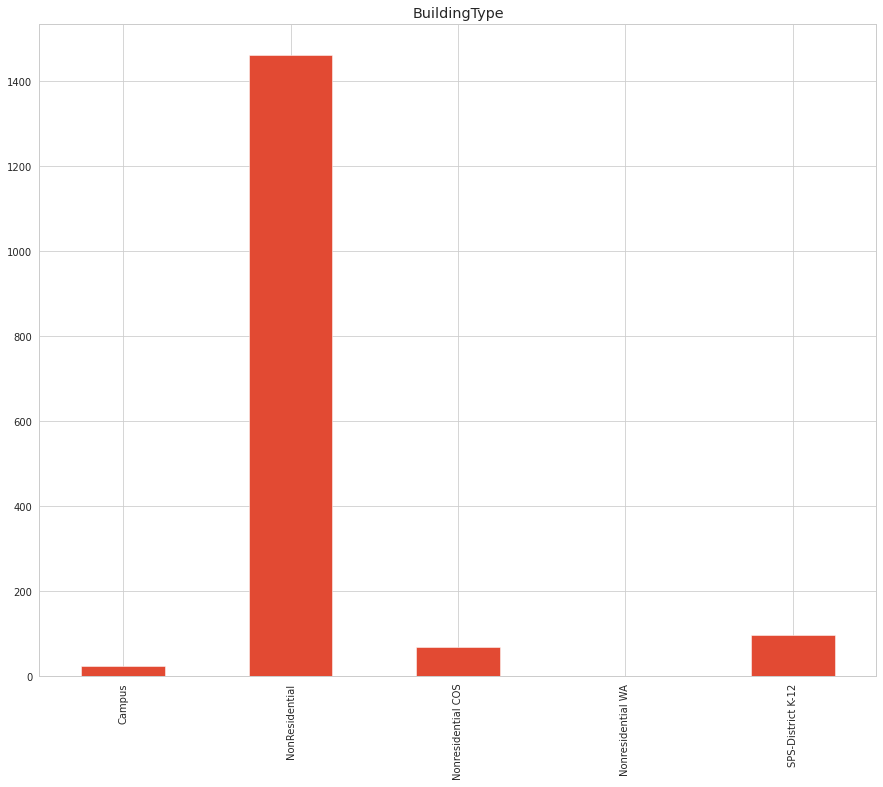

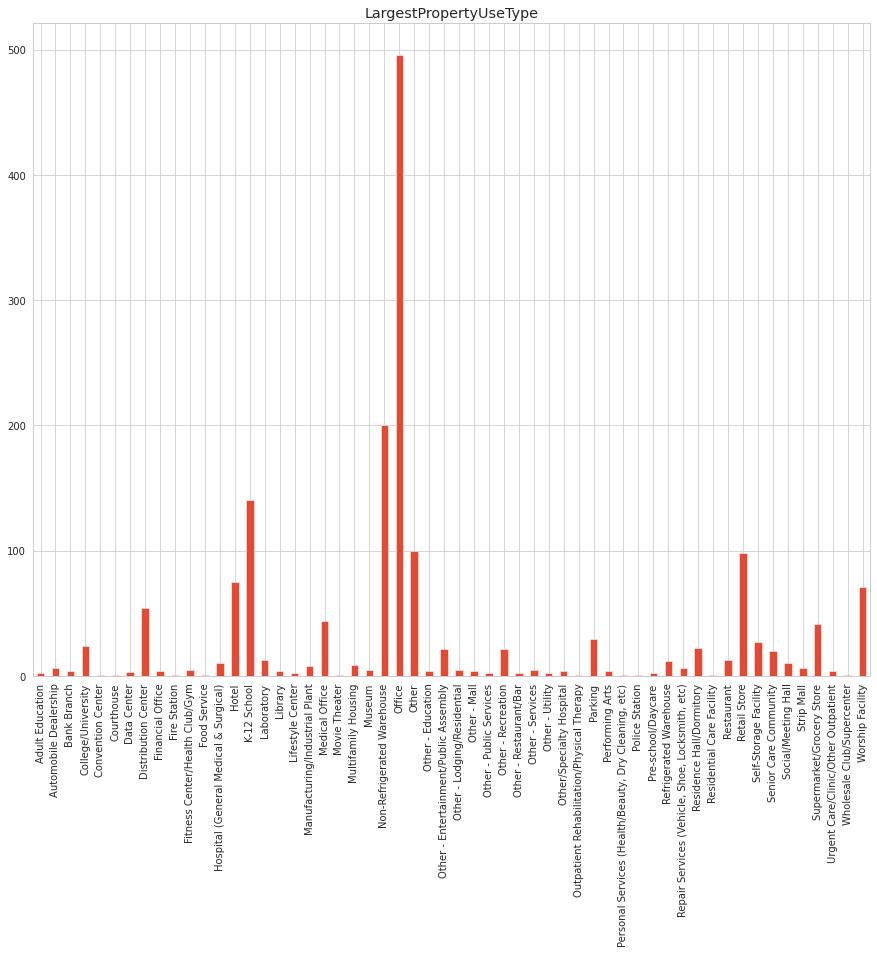

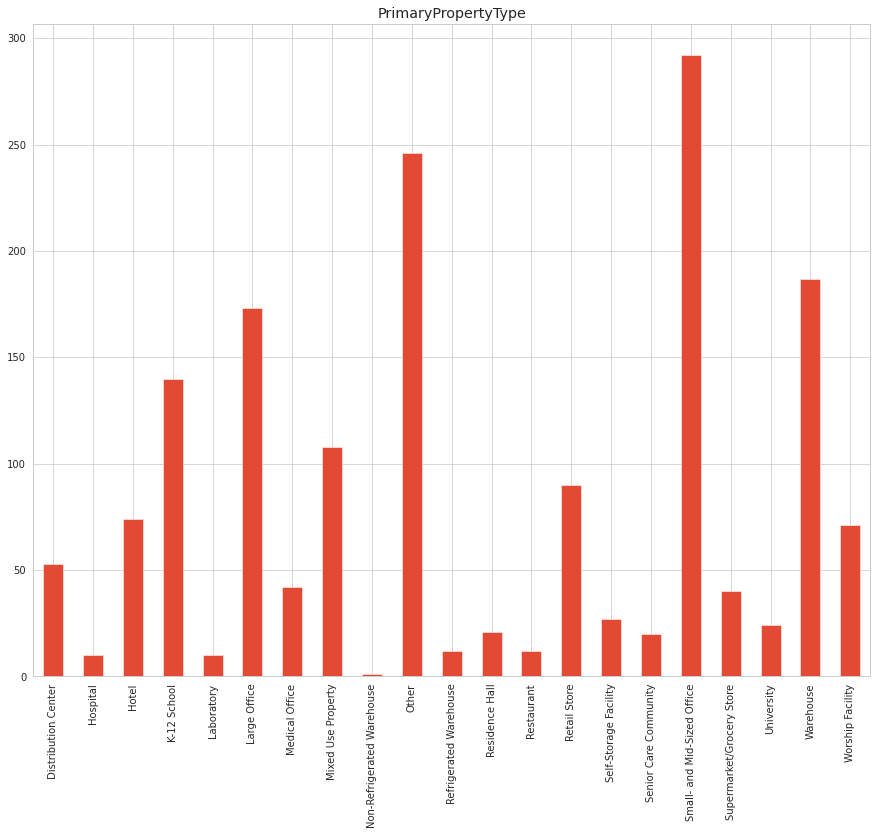

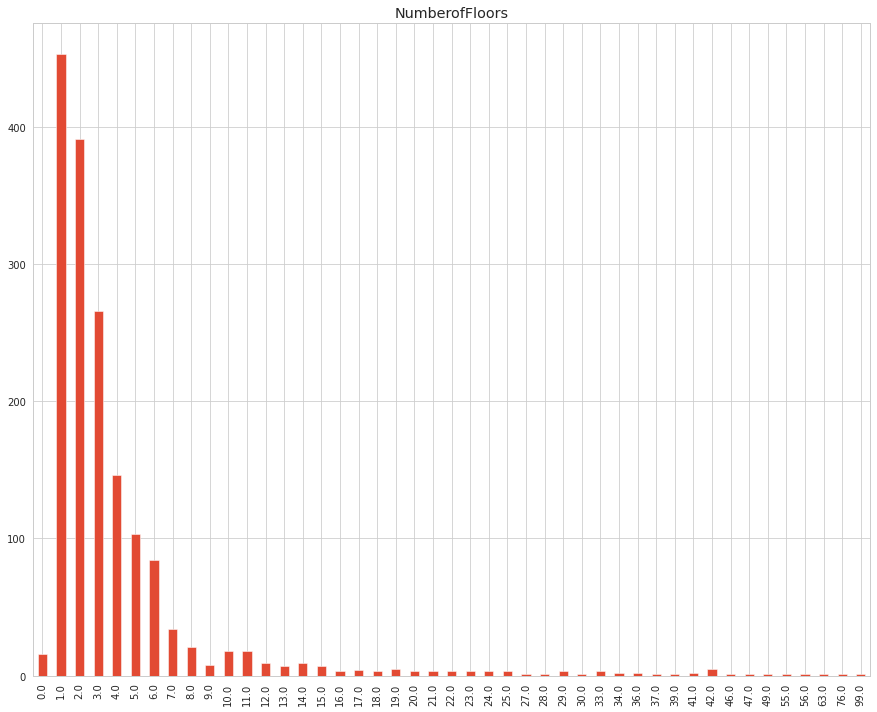

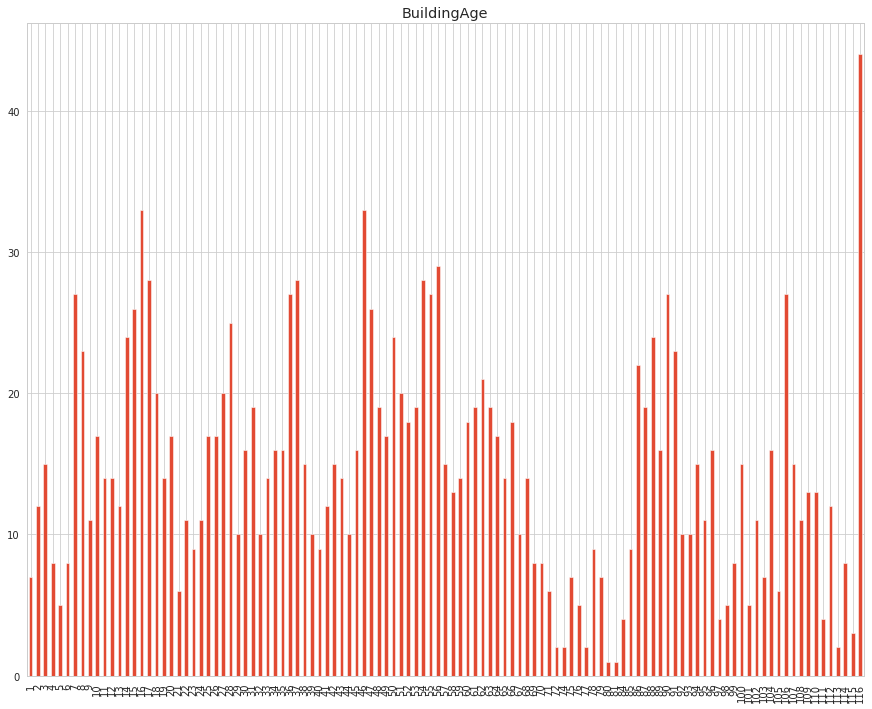

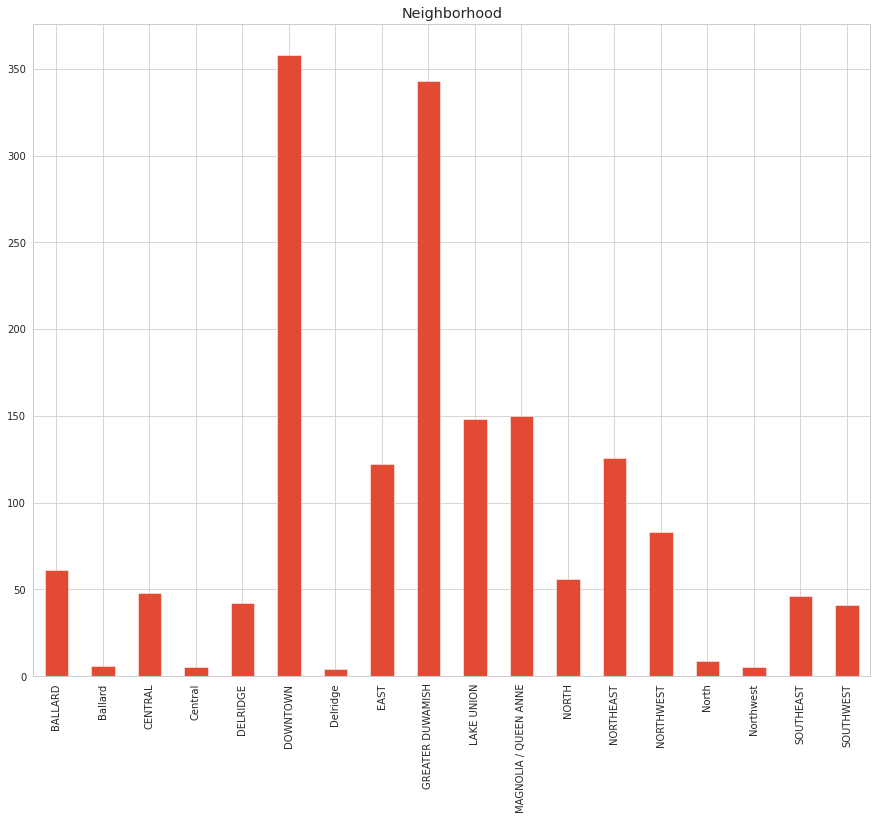

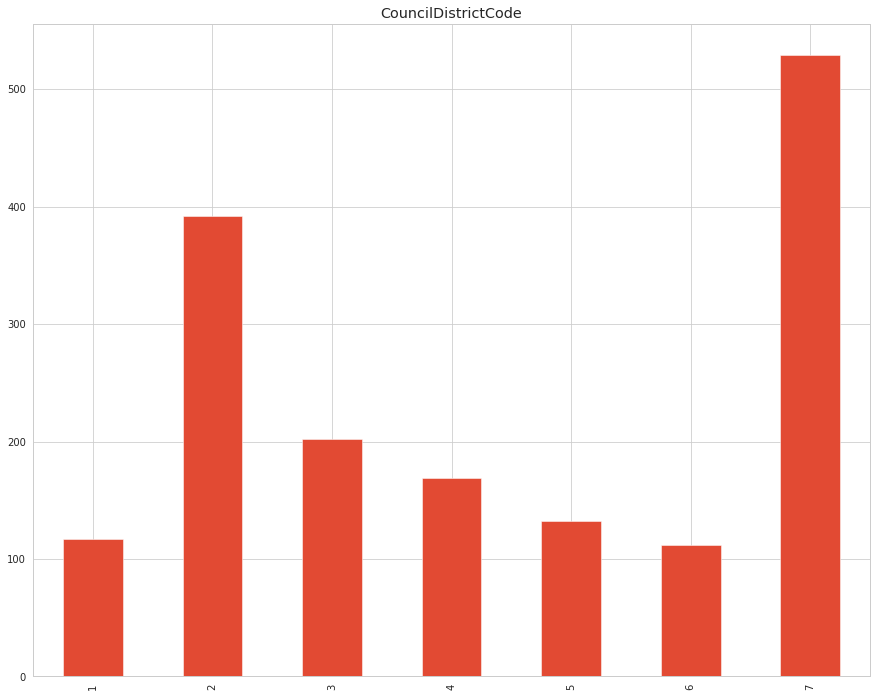

In [45]:
qualitative_columns = ['BuildingType', 'LargestPropertyUseType', 'PrimaryPropertyType', 'NumberofFloors','BuildingAge', 
                       'Neighborhood', 'CouncilDistrictCode']

for column in qualitative_columns:
    fig = plt.figure(figsize=(15,12))
    data[column].value_counts().sort_index(axis=0).plot(kind='bar')
    plt.title(column)
    plt.show()

### On peut constater plusieurs faits;

### les types de batiments sont inégalement représentés, on a surtout des batiments de types non résidentiels qui sont essentiellement des bureaux
### certains quartiers sont très peu représentés (probablement les quartiers résidentiels avec les données qu'on a supprimé de l'analyse) mais cette inégalité est peu visible au niveau des districts
### on a peu de construction bâtie entre 1930 et 1947 ce qui est expliqué par la crise de 29 et la 2nde guerre mondiale.
### on a peu de construction récentes (ce qui semble normal les terrains ne sont plus à batir)
### plus les constructions sont élevées, moins elles sont nombreuses.

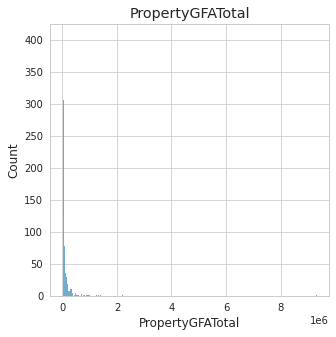

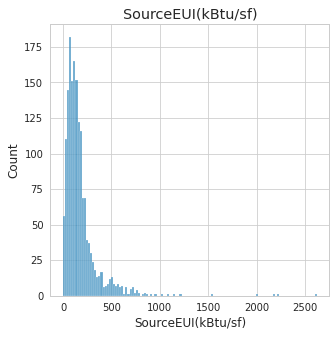

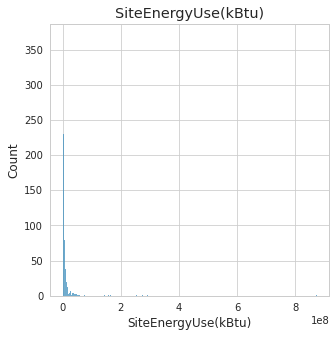

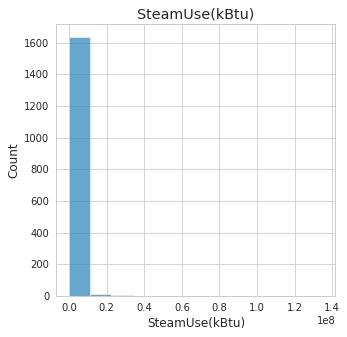

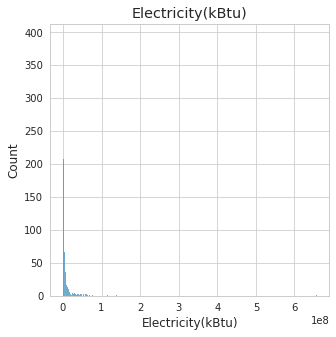

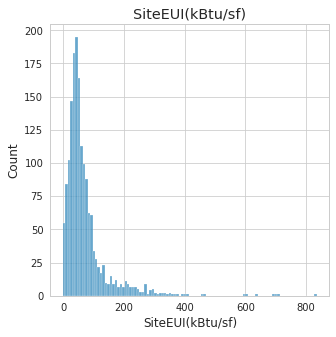

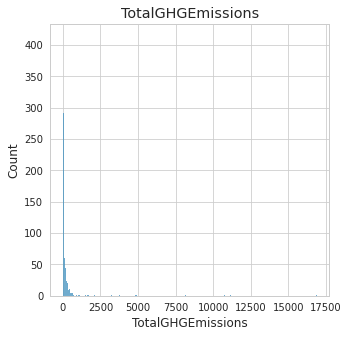

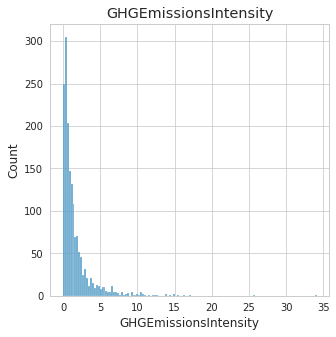

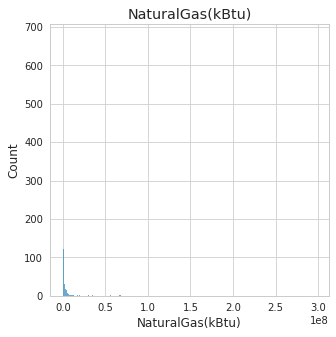

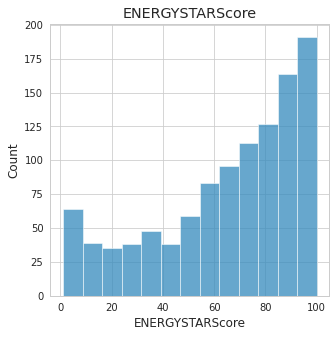

In [46]:
quantitative_columns = ['PropertyGFATotal', 'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 
                        'SiteEUI(kBtu/sf)', 'TotalGHGEmissions', 'GHGEmissionsIntensity', 'NaturalGas(kBtu)', 'ENERGYSTARScore']
for column in quantitative_columns:
    fig = plt.figure(figsize=(5,5))
    sns.histplot(data[column])
    plt.title(column)
    plt.show()

### On peut constater plusieurs faits:

### il y a beaucoup de bâtiments avec une faible surface de plancher brut (comme le nombre d'étage) mais à eux tous il représente la plupart de la surface de plancher.
### beaucoup de batiment consomment peu d'énergie mais qu'à eux tous ce sont eux qui consomment le plus
### il y a peu de batiments qui consomment une très grande quantité d'énergie et à eux tous ils consomment finalement assez peu.
### ce constat est assez similaire avec l'émission de gazs à effet de serre.
### Cela laisse à présager que:

### la consommation énergétique pourrait être corrélé à l'émission de gazs à effet de serre.
### la consommation énergétique et donc les émissions de gazs à effet de serre pourraient être corrélés au nombre d'étage des buildings.


### 2.2. Analyse multivariée

### 2.3.Corrélations

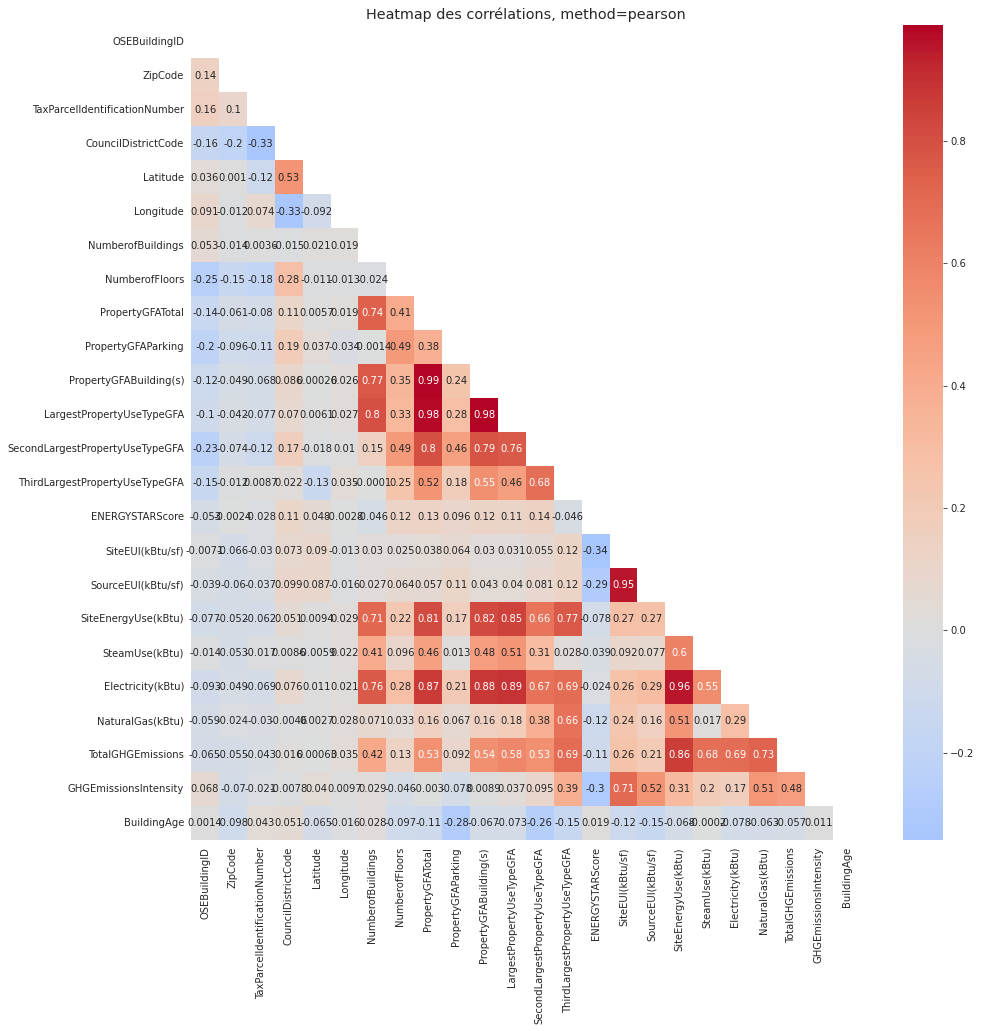

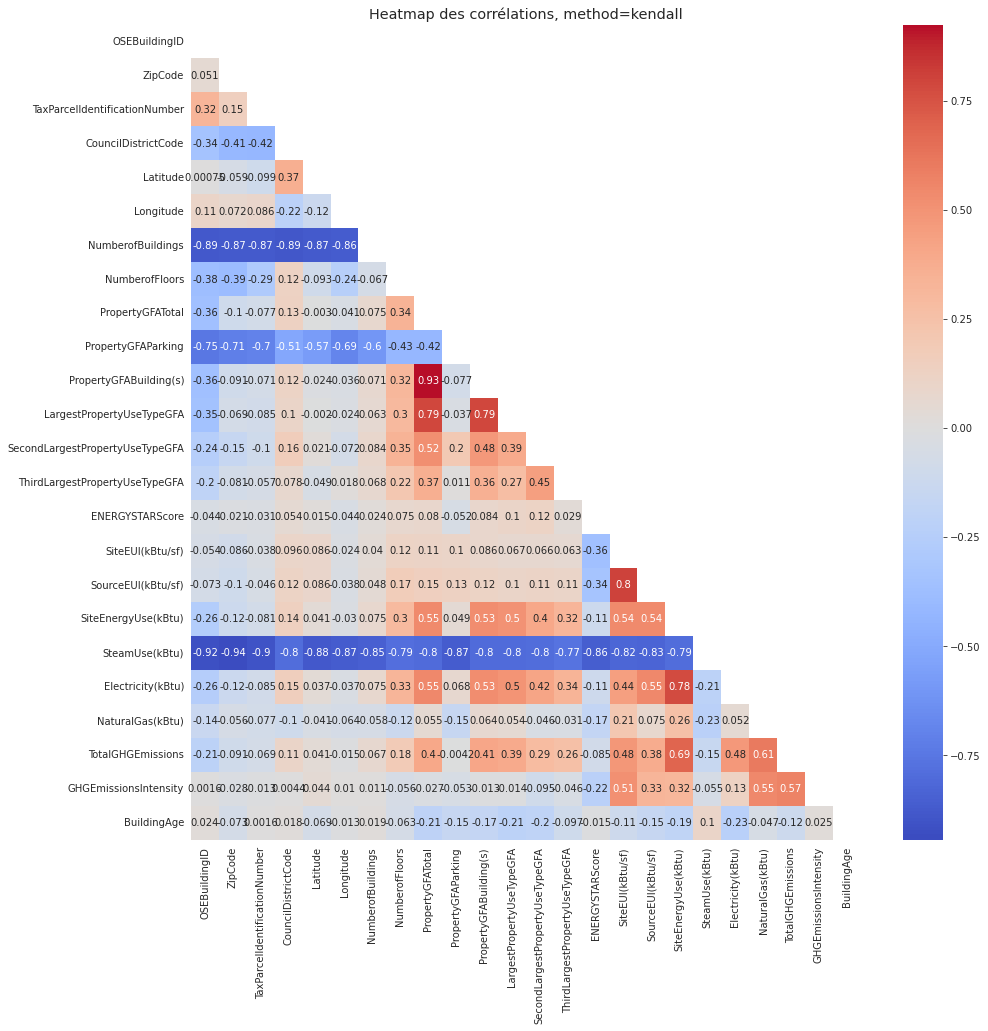

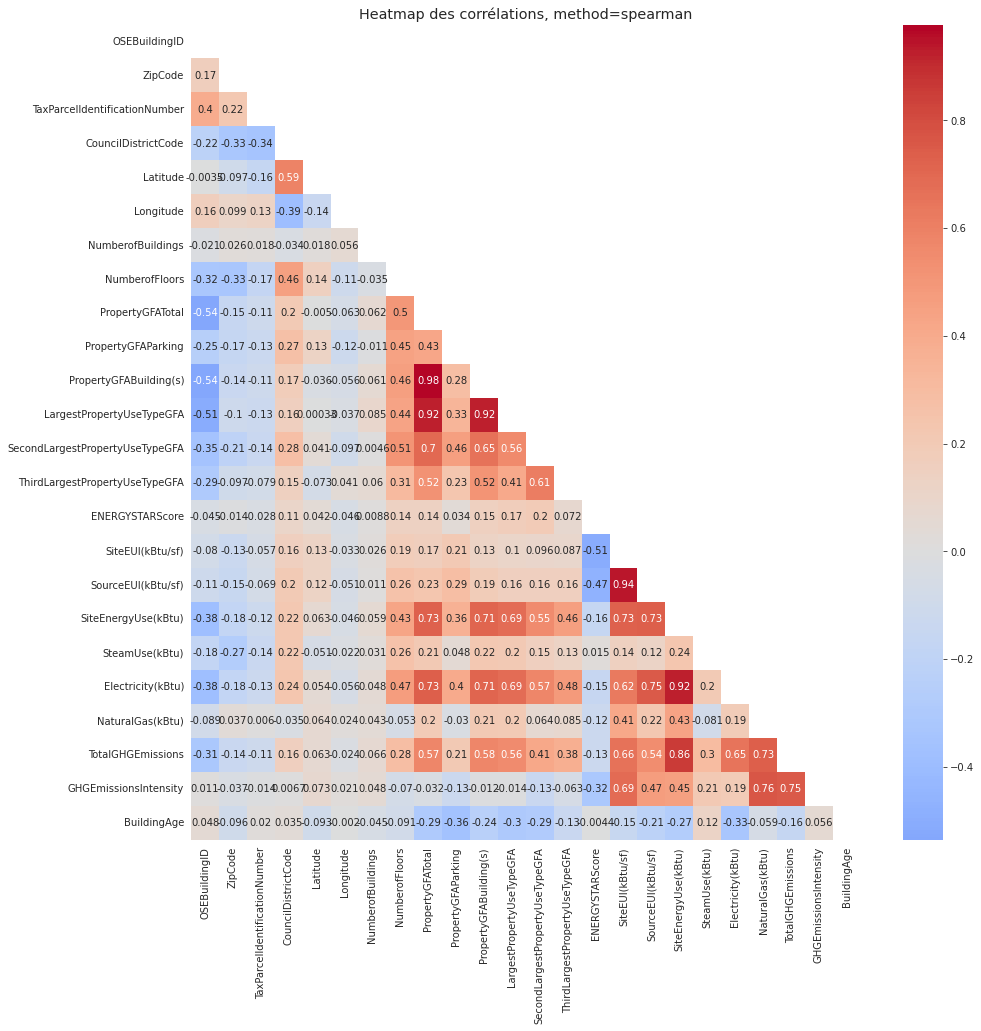

In [47]:
corr_methods=  ['pearson','kendall', 'spearman']

'''
pearson : standard correlation coefficient
kendall : Kendall Tau correlation coefficient
spearman :  Spearman rank correlation
'''

for corr_method in corr_methods:
    corr = data.corr(method=corr_method)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(15,15))
    ax = sns.heatmap(corr, annot=True, mask=mask, center=0, cmap="coolwarm")
    plt.title('Heatmap des corrélations, method={}'.format(corr_method))
    plt.show()

### Pour les varaibles à prédire TotalGHGEmissions et SiteEnergyUse(kBtu), on remarque des corrélations linéaires quasi similaires avec les variables de relevés (les consommations) mais également avec le nombre de batiments ou d'étages ains que les surfaces au sol.

### On remarque sur ce Heatmap de fortes corrélations linéaires entre variables. Ces corrélations peuvent amener des problèmes de colinéarité dans nos futurs modèles. Isolons donc les paires de variables avec des corrélations de Pearson supérieurs à 0.7 :

In [48]:
threshold = 0.7
corr_pairs = corr.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold)])
               .reset_index().rename(columns={0:'corr_coeff'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('corr_coeff', ascending=False)

,level_0,level_1,corr_coeff
30,PropertyGFATotal,PropertyGFABuilding(s),0.977917
28,SourceEUI(kBtu/sf),SiteEUI(kBtu/sf),0.937622
26,PropertyGFATotal,LargestPropertyUseTypeGFA,0.923709
24,LargestPropertyUseTypeGFA,PropertyGFABuilding(s),0.920591
22,Electricity(kBtu),SiteEnergyUse(kBtu),0.920529
20,SiteEnergyUse(kBtu),TotalGHGEmissions,0.858547
18,NaturalGas(kBtu),GHGEmissionsIntensity,0.759329
16,Electricity(kBtu),SourceEUI(kBtu/sf),0.748191
14,TotalGHGEmissions,GHGEmissionsIntensity,0.747492
12,PropertyGFATotal,Electricity(kBtu),0.734799


In [49]:
corr = data.corr()
corr_columns = corr.columns[((corr < 1) & (corr > 0.7)).any(axis=0)]
display(corr_columns)

Index(['NumberofBuildings', 'PropertyGFATotal', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'SiteEUI(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity'],
      dtype='object')

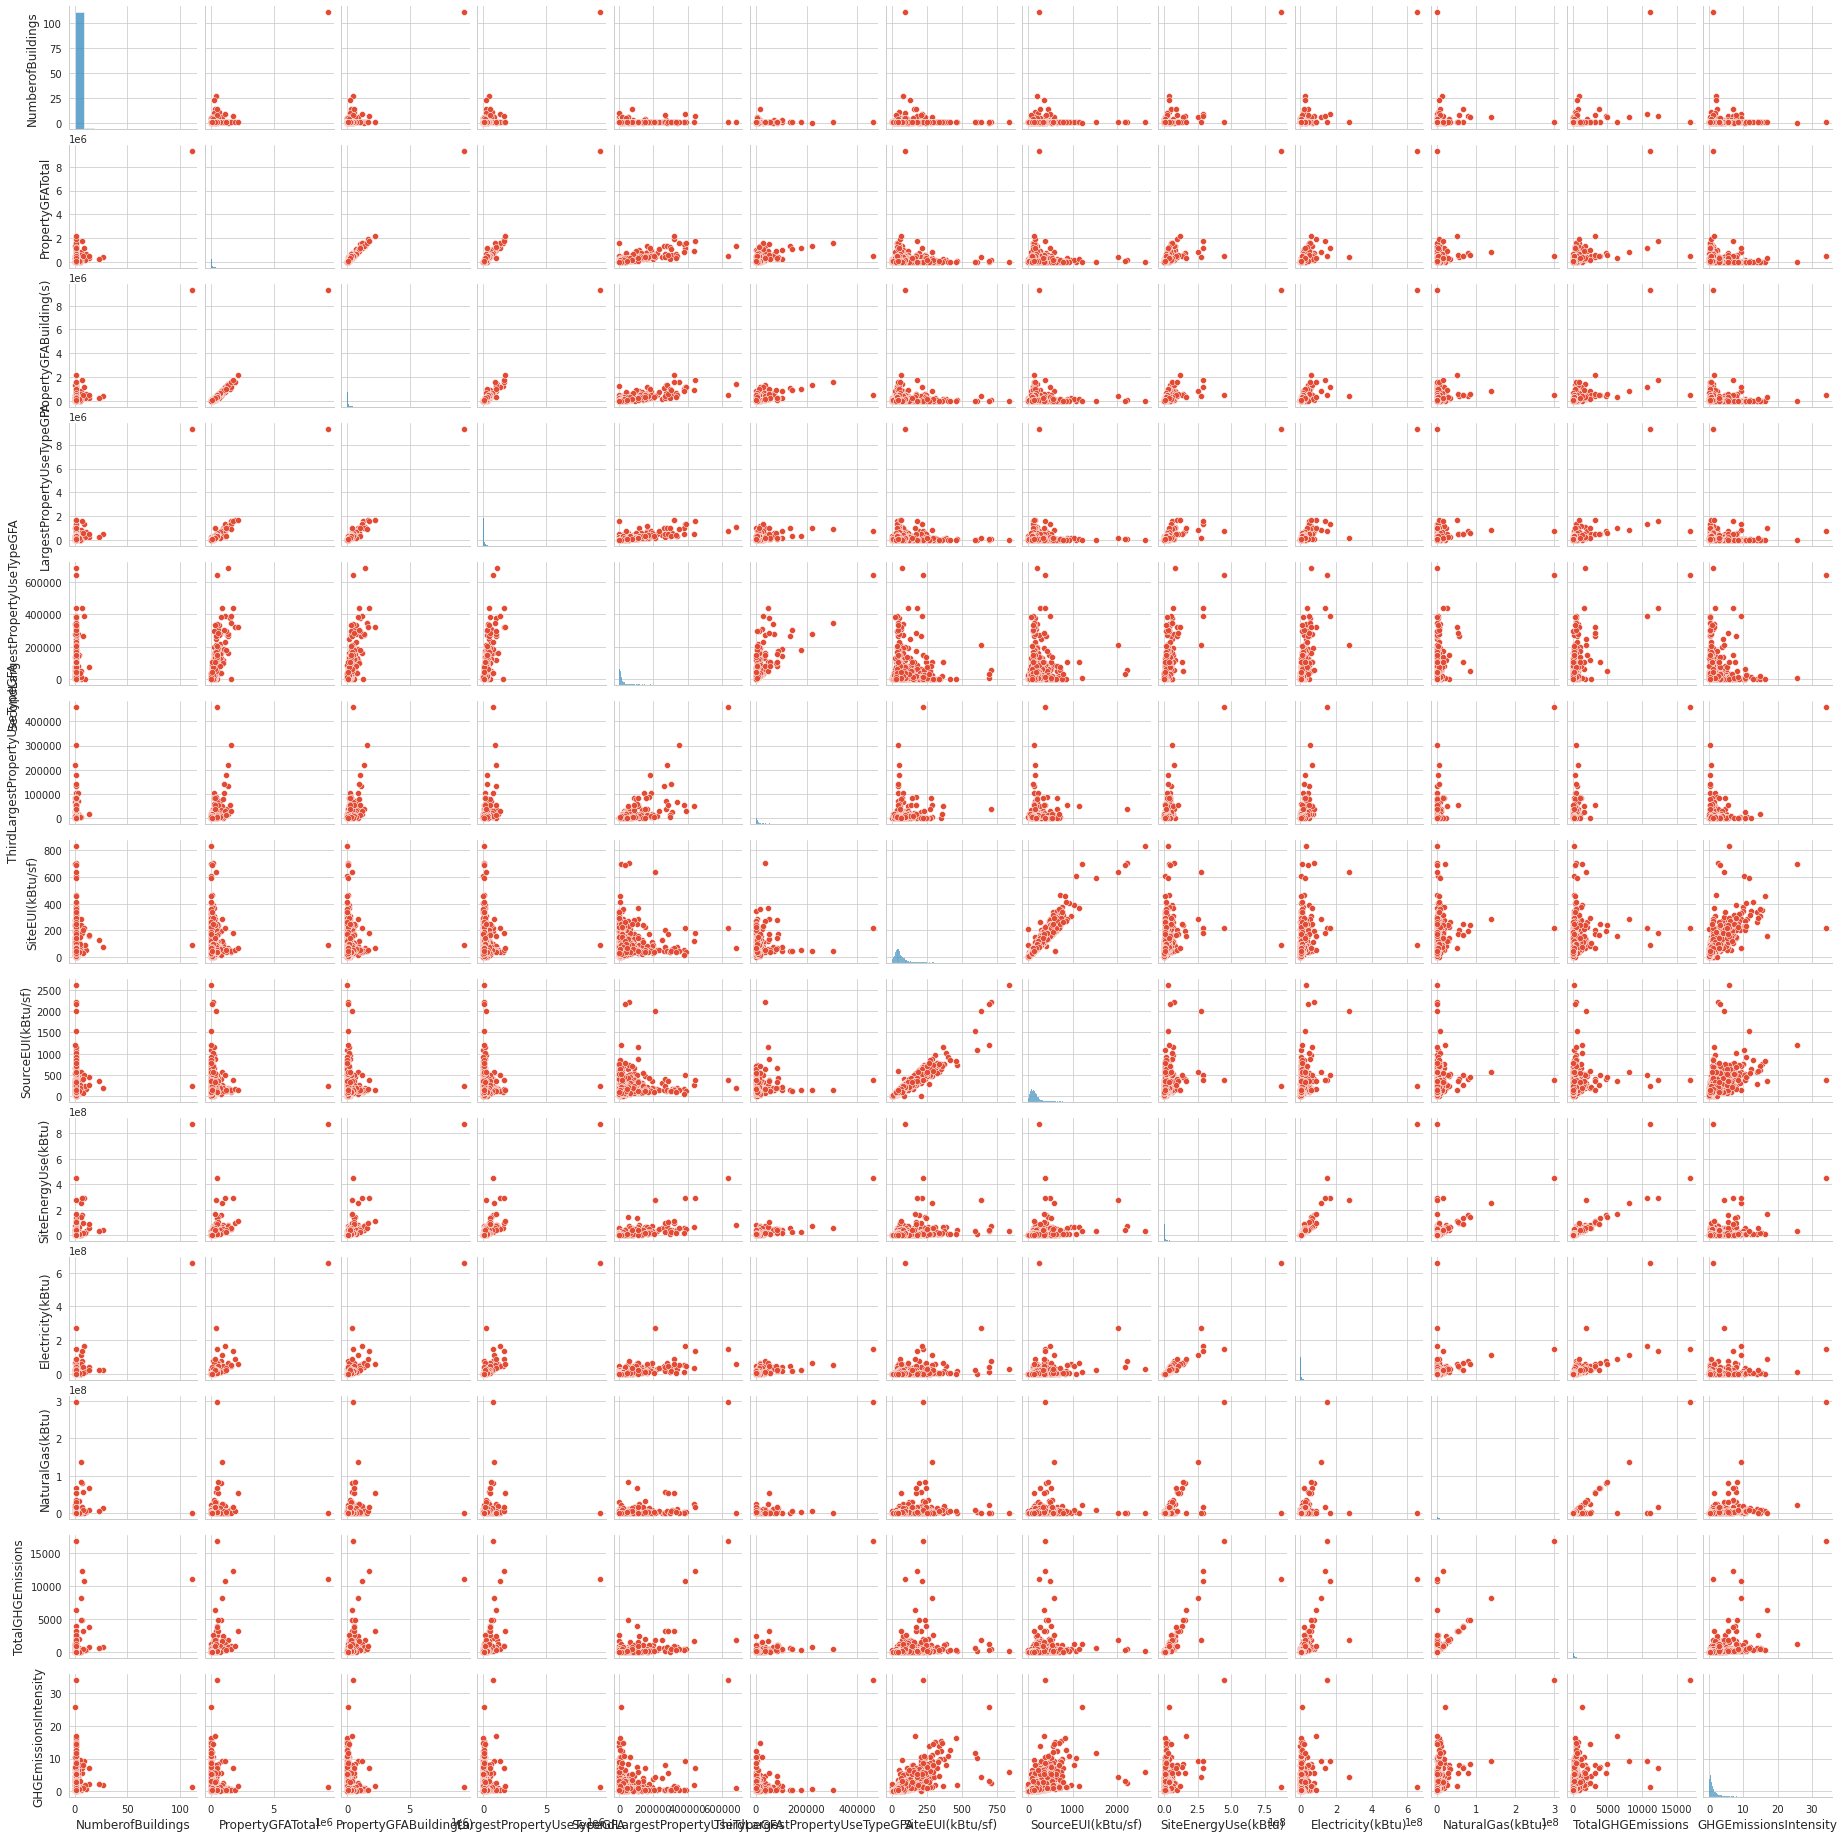

In [50]:
sns.pairplot(data[corr_columns], height = 2)

### On remarque que les variables suffixées GFA présentent de fortes corrélations avec plusieurs autres variables. Nous allons donc créer de nouvelles variables pour tenter de gommer ces corrélations linéaires :  Nous allons donc créer une variable nous donnant le nombre total d'usage du bâtiment, puis supprimer la liste complète des usages :

In [51]:
data['TotalUseTypeNumber'] = [str(word).count(",") + 1 for word in data['ListOfAllPropertyUseTypes'].str.split(',')]
data.drop('ListOfAllPropertyUseTypes', axis=1)

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,...,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity,BuildingAge,TotalUseTypeNumber
256,400,NonResidential,Small- and Mid-Sized Office,GALLAND & SENECA BUILDINGS,1201 2ND AVE,SEATTLE,WA,98101.0,1974700175,7,...,6525887.00,0.0,6488262.0,37893.0,No,Compliant,47.24,0.20,109,1
288,435,NonResidential,Other,WASHINGTON STATE CONVENTION CENTER,800 CONVENTION PL,SEATTLE,WA,98101.0,1978200105,7,...,77164568.00,16811018.0,58718556.0,1637420.0,No,Compliant,1793.90,1.10,25,2
294,442,NonResidential,Large Office,KING BROADCASTING,333 DEXTER AVE N,SEATTLE,WA,98109.0,1991200870,7,...,16760217.00,0.0,16760914.0,0.0,No,Compliant,116.84,0.23,68,5
336,499,NonResidential,Small- and Mid-Sized Office,ASIAN COUNSELING and REFERRAL SERVICE BUILDING,3639 MARTIN LUTHER KING JR WAY S,SEATTLE,WA,98144.0,1426300170,2,...,4476997.00,0.0,2234200.0,2242889.0,Yes,Compliant,134.69,1.63,7,2
378,559,NonResidential,Large Office,YALE & THOMAS,325 EASTLAKE AVE E,SEATTLE,WA,98109.0,6847700105,7,...,12662456.00,0.0,9657951.0,3004906.0,No,Compliant,226.92,0.99,34,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6418,50069,NonResidential,Small- and Mid-Sized Office,Airport - Main Terminal,7277 Perimeter Rd.,Seattle,WA,98108.0,2824049007,2,...,4420650.50,0.0,2167029.0,2253621.0,False,Compliant,134.80,5.39,87,1
6419,50070,NonResidential,Other,Tennis Center Sand Point,7135 Sportsfield Drive NE,Seattle,WA,98155.0,225049062,4,...,2925780.00,0.0,1901620.0,1024160.0,False,Compliant,67.65,0.94,3,1
6425,50081,NonResidential,K-12 School,Hamlin Robinson School,1701 20th Ave South,Seattle,WA,98144.0,7548300840,3,...,1325972.75,0.0,1325973.0,0.0,False,Compliant,9.24,0.21,1,2
6434,50094,NonResidential,Mixed Use Property,AIBS,601 Westlake Ave N.,Seattle,WA,98109.0,4088803385,7,...,39364116.00,0.0,23636804.0,15727308.0,False,Compliant,1000.06,2.90,1,6


### Nous allons à présent convertir les différentes surfaces (Buildings et Parking) en pourcentage de la surface totale et nous conserverons uniquement ces 2 variables en supprimant les variables LargestPropertyUseTypeGFA, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseTypeGFA :

In [52]:
gfa_features = ['PropertyGFATotal', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA','PropertyGFAParking',
       'ThirdLargestPropertyUseTypeGFA']
data[['TotalUseTypeNumber'] + gfa_features].head(10)

,TotalUseTypeNumber,PropertyGFATotal,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,PropertyGFAParking,ThirdLargestPropertyUseTypeGFA
256,1,98370,72450,98370.0,NaN,25920,NaN
288,2,1400000,1400000,1072000.0,686750.0,0,NaN
294,5,193788,155934,138672.0,47539.0,37854,11166.0
336,2,76598,55188,55188.0,21410.0,21410,NaN
378,2,186971,186971,186977.0,115477.0,0,NaN
468,2,434475,184475,434475.0,250000.0,250000,NaN
496,2,192960,160800,135173.0,32000.0,32160,NaN
529,2,131143,43983,120290.0,10853.0,87160,NaN
587,3,83448,67969,42527.0,27961.0,15479,529.0
658,1,28568,28568,28568.0,NaN,0,NaN


In [53]:
#On calcule les ratios
data['GFABuildingRate'] = (round((data['PropertyGFABuilding(s)'].fillna(0)
                                  /data['PropertyGFATotal'].fillna(0)),5))
data['GFAParkingRate'] = (round((data['PropertyGFAParking'].fillna(0)
                                 /data['PropertyGFATotal'].fillna(0)),5))

#On supprime les variables inutiles
data = data.drop(['LargestPropertyUseTypeGFA', 
           'SecondLargestPropertyUseTypeGFA',
           'SecondLargestPropertyUseType',
           'ThirdLargestPropertyUseTypeGFA',
           'ThirdLargestPropertyUseType',
           'PropertyGFAParking',
           'PropertyGFABuilding(s)'],
         axis=1)

#On complète les usages de la partie la plus large
data['LargestPropertyUseType'] = data['LargestPropertyUseType'].fillna("Unknown")
data['NumberofFloors'] = data['NumberofFloors'].fillna(1)

### Nous pouvons également calculer la surface moyenne par bâtiment et par étage :

In [54]:
data['GFAPerBuilding'] = round((data['PropertyGFATotal'] / data['NumberofBuildings']),3)
data['GFAPerFloor'] = round((data['PropertyGFATotal'] / data['NumberofFloors']),3)

### Les données sont à présent bien complétées. Nous allons vérifier l'impact de ce feature engineering sur la matrice des corrélations linéaires :

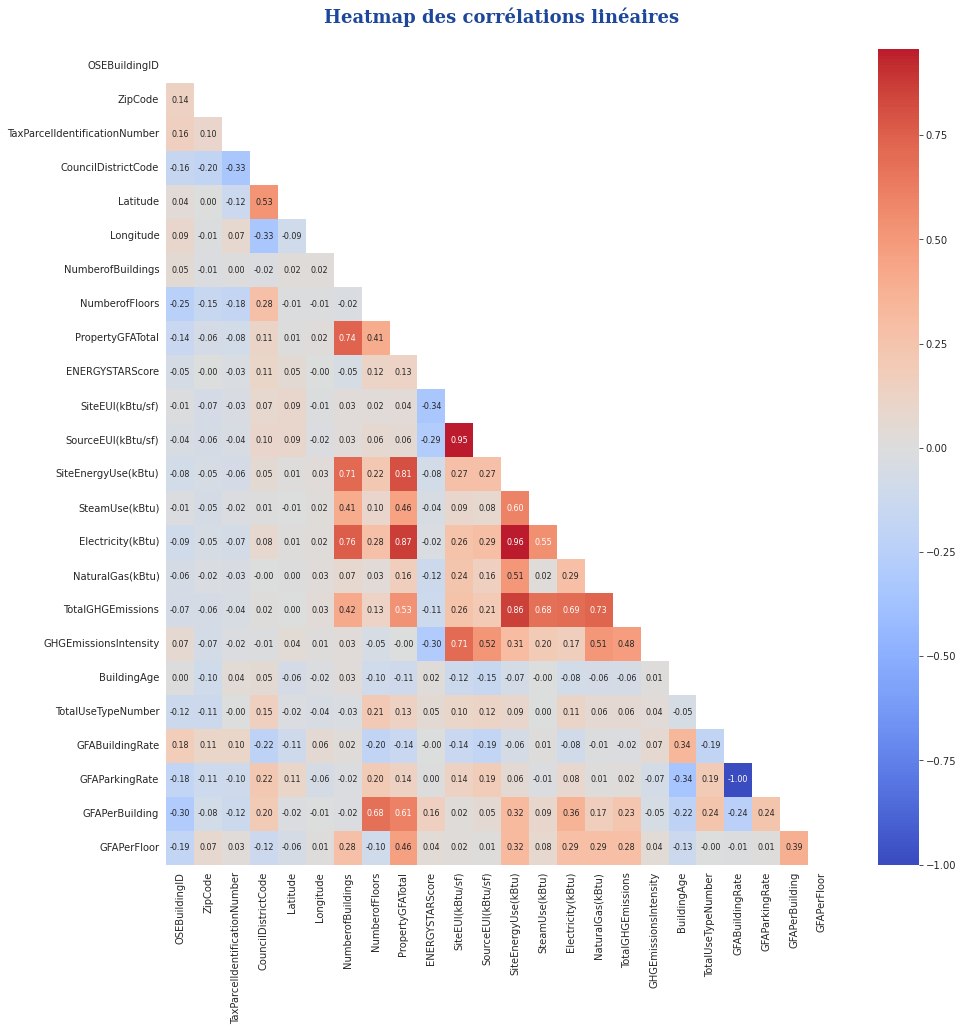

In [55]:
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size':8}, 
                 mask=mask, center=0, cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n", 
          fontdict=font_title)
plt.show()

In [56]:
threshold = 0.7
corr_pairs = corr.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold)])
               .reset_index().rename(columns={0:'corr_coeff'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('corr_coeff', ascending=False)

,level_0,level_1,corr_coeff
20,SiteEnergyUse(kBtu),Electricity(kBtu),0.956274
18,SourceEUI(kBtu/sf),SiteEUI(kBtu/sf),0.949054
16,PropertyGFATotal,Electricity(kBtu),0.868588
14,SiteEnergyUse(kBtu),TotalGHGEmissions,0.862778
12,PropertyGFATotal,SiteEnergyUse(kBtu),0.809491
10,Electricity(kBtu),NumberofBuildings,0.757630
8,NumberofBuildings,PropertyGFATotal,0.735429
6,NaturalGas(kBtu),TotalGHGEmissions,0.730721
4,NumberofBuildings,SiteEnergyUse(kBtu),0.711908
2,GHGEmissionsIntensity,SiteEUI(kBtu/sf),0.707376


### Vérification de multicolinéarité avec le VIF (Variance Inflation Factor) :  
### VIF=1/1-R*R


In [57]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

strong_corr_features = list(set(list(strong_corr['level_0'].values) + list(strong_corr['level_1'].values)))
X = data[strong_corr_features].replace([np.inf, -np.inf], np.nan)
X = X.dropna()

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                   for i in range(len(X.columns))]
vif_data[vif_data['VIF'] > 5]

,feature,VIF
1,Electricity(kBtu),253.206679
2,NumberofBuildings,5.519369
3,GHGEmissionsIntensity,6.020829
4,SiteEUI(kBtu/sf),35.278861
5,SourceEUI(kBtu/sf),25.850442
6,TotalGHGEmissions,55.687153
7,PropertyGFATotal,5.647298
8,NaturalGas(kBtu),7.542642
10,SiteEnergyUse(kBtu),538.751407


### Des scores VIF supérieur à 5 indiquent généralement une forte multicolinéarité. Ces variables fortement corrélées risquent d'impacter nos modèles.
### Les features suffixées EUI(kBtu/sf), sont des variables dont les valeurs sont ramenées à la surface par étage. Nous allons les supprimer car nous avons créer des variables pouvant permettre de ramener nos données à l'étage ou au building. Idem pour la variable GHGEmissionsIntensity

In [58]:
data=data.drop(['GHGEmissionsIntensity','SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)'],axis =1)

### 2.4. Analyse des variables à prédire

#### Pour rappel, les 2 variables à prédire dans le cadre de notre mission sont :

### TotalGHGEmissions
### SiteEnergyUse(kBtu)
#### Nous allons donc réaliser quelques analyses exploratoires sur ces features 

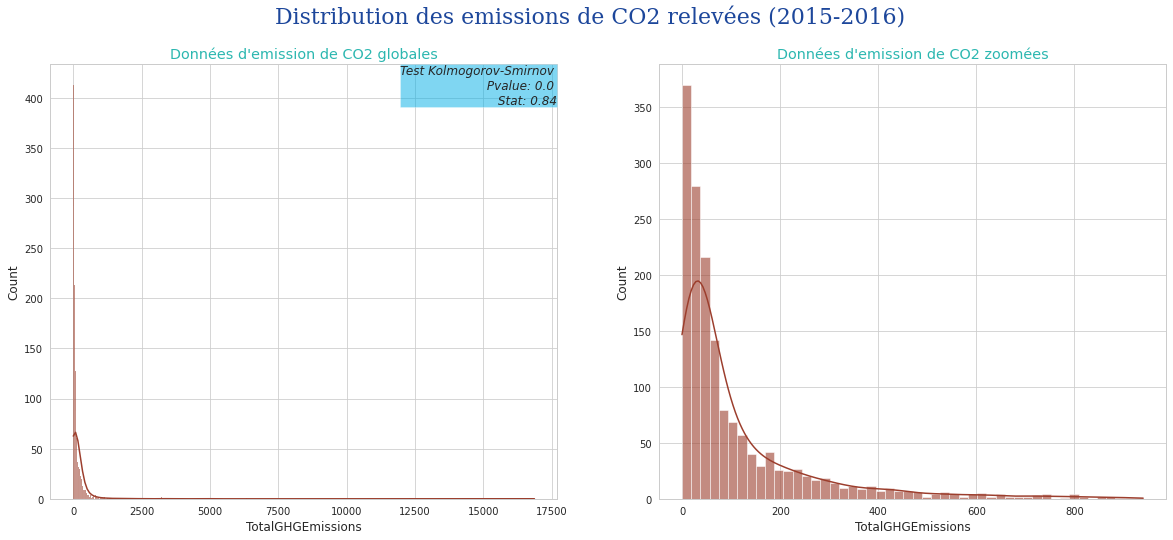

In [59]:
import scipy.stats as stats

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
left, width = 0, 1
bottom, height = 0, 1
right = left + width
top = bottom + height

sns.histplot(data=data, x="TotalGHGEmissions", kde=True, ax=axes[0], color="#9C3E2D", alpha=0.6)
axes[0].set_title("Données d'emission de CO2 globales", color='#2cb7b0')

#Test de Kolmogorov-Smirnov
kstest = stats.kstest(data['TotalGHGEmissions'].notnull(),'norm')
axes[0].text(right, top, 'Test Kolmogorov-Smirnov \n Pvalue: {:.2} \n Stat: {:.2}'.format(kstest.pvalue, kstest.statistic),
            horizontalalignment='right',
            verticalalignment='top',
            style='italic', transform=axes[0].transAxes, fontsize = 12,
            bbox={'facecolor':'#00afe6', 'alpha':0.5, 'pad':0})

sns.histplot(data=data[(data['TotalGHGEmissions']< 1000)], x="TotalGHGEmissions", kde=True, ax=axes[1], color="#9C3E2D", alpha=0.6)
axes[1].set_title("Données d'emission de CO2 zoomées", color='#2cb7b0')

plt.suptitle("Distribution des emissions de CO2 relevées (2015-2016)", 
             fontdict=font_title, fontsize=22)
plt.show()


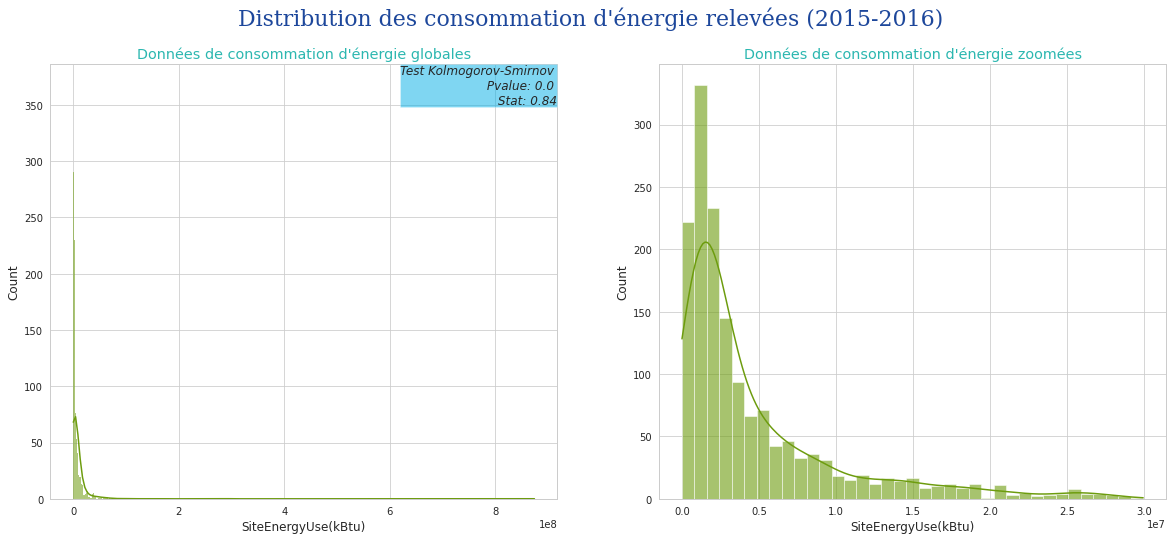

In [60]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))

sns.histplot(data=data, x="SiteEnergyUse(kBtu)", kde=True, ax=axes[0], color="#6D9C0E", alpha=0.6)
axes[0].set_title("Données de consommation d'énergie globales", color='#2cb7b0')

#Test de Kolmogorov-Smirnov
kstest = stats.kstest(data['SiteEnergyUse(kBtu)'].notnull(),'norm')
axes[0].text(right, top, 'Test Kolmogorov-Smirnov \n Pvalue: {:.2} \n Stat: {:.2}'.format(kstest.pvalue, kstest.statistic),
            horizontalalignment='right',
            verticalalignment='top',
            style='italic', transform=axes[0].transAxes, fontsize = 12,
            bbox={'facecolor':'#00afe6', 'alpha':0.5, 'pad':0})

sns.histplot(data=data[(data['SiteEnergyUse(kBtu)']< 0.3*10**8)], x="SiteEnergyUse(kBtu)", kde=True, ax=axes[1], color="#6D9C0E", alpha=0.6)
axes[1].set_title("Données de consommation d'énergie zoomées", color='#2cb7b0')

plt.suptitle("Distribution des consommation d'énergie relevées (2015-2016)", 
             fontdict=font_title, fontsize=22)
plt.show()

### En se basant sur les projections obtenus et les résultats des tests de Kolmogorov-Smirnov (Pvalue < au niveau de test de 5%) on rejette donc l'hypothèse de normalité des distributions de ces variables.

### Projettons à présent les scatterplots des distribition de ces 2 variables entre elles :

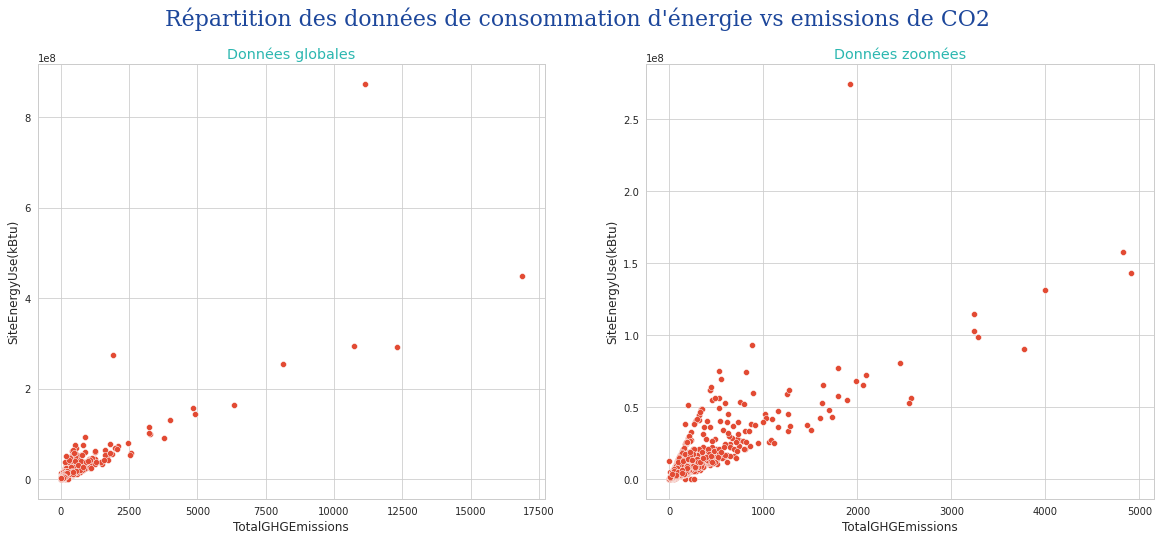

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.scatterplot(data=data, x="TotalGHGEmissions", y="SiteEnergyUse(kBtu)", ax=axes[0])
axes[0].set_title("Données globales", color='#2cb7b0')
sns.scatterplot(data=data[(data['TotalGHGEmissions'] < 5000)], x="TotalGHGEmissions", y="SiteEnergyUse(kBtu)", ax=axes[1])
axes[1].set_title("Données zoomées", color='#2cb7b0')
plt.suptitle("Répartition des données de consommation d'énergie vs emissions de CO2", fontdict=font_title, fontsize=22)
plt.show()

### on remarque ici que la répartion des données d'emission de CO2 en fonction de la consommation d'énergie ne suivent pas uniquement 1 seule droite de régression linéaire si l'on zoom sur les données les plus représentées.

### Nous allons à présent regarder la répartition de ces 2 variables en fonction du type de bâtiement.

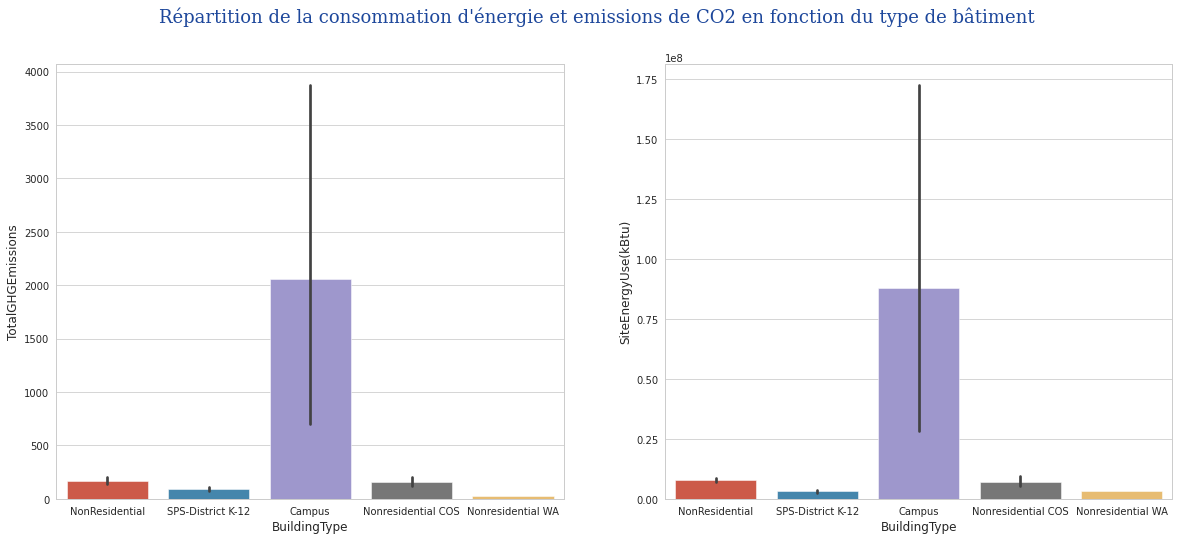

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.barplot(x='BuildingType',y='TotalGHGEmissions',data=data, ax=axes[0])
sns.barplot(x='BuildingType',y='SiteEnergyUse(kBtu)',data=data, ax=axes[1])
plt.suptitle("Répartition de la consommation d'énergie et emissions de CO2 en fonction du type de bâtiment", 
             fontdict=font_title, fontsize=18)
plt.show()

### Sur ces diagrammes en barre, les campus se démarquent largement en terme de consommation et de rejets de CO2. Regardons à présent si l'âge des bâtiments a un impact sur les émissions de CO2 :

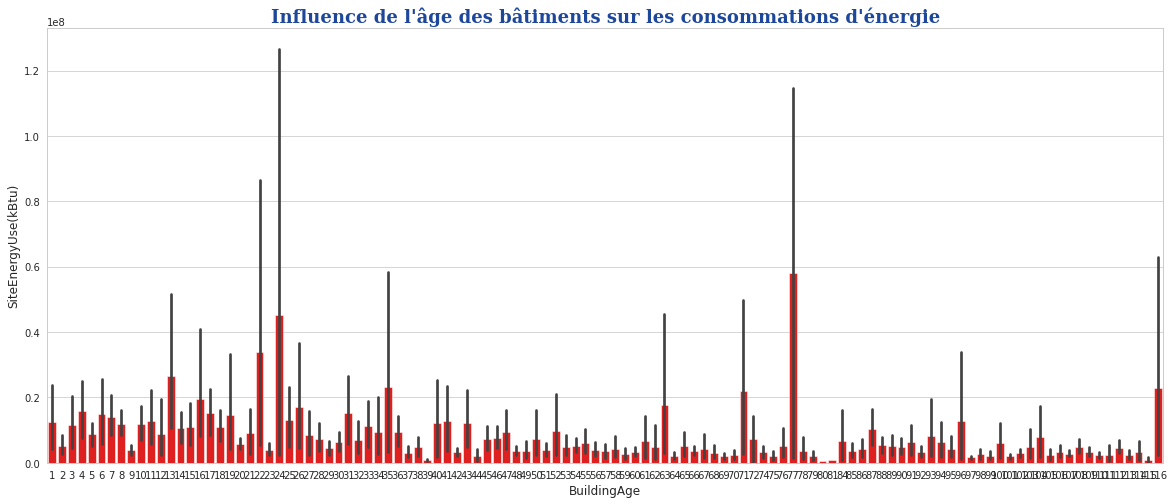

In [63]:
fig, axes = plt.subplots( figsize=(20,8))
sns.barplot(data=data,x=data['BuildingAge'], y="SiteEnergyUse(kBtu)", color = "red" )
plt.title("Influence de l'âge des bâtiments sur les consommations d'énergie", fontdict=font_title)

plt.show()

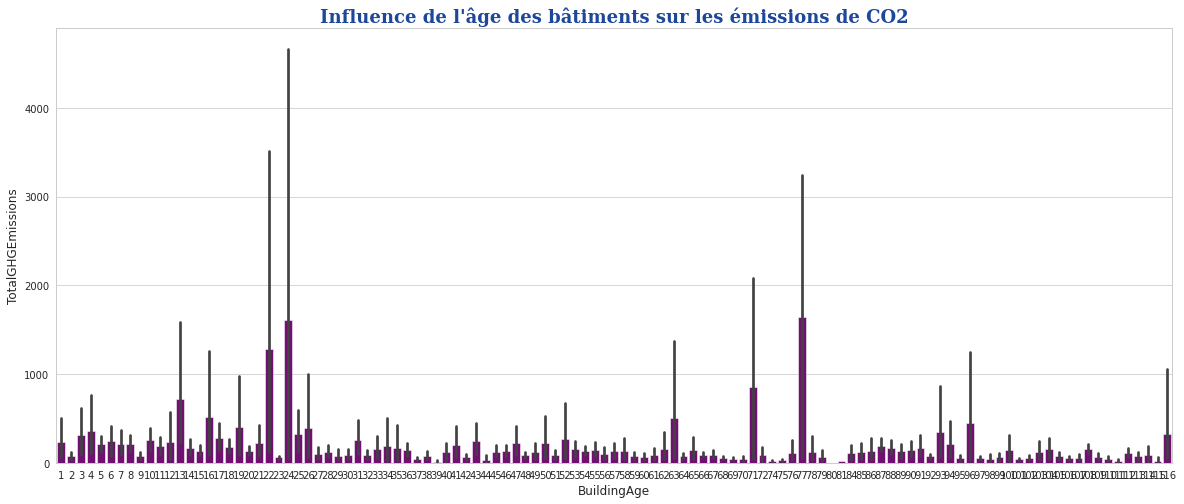

In [64]:
fig, axes = plt.subplots( figsize=(20,8))
sns.barplot(data=data,x=data['BuildingAge'], y="TotalGHGEmissions", color = "purple" )
plt.title("Influence de l'âge des bâtiments sur les émissions de CO2", fontdict=font_title)
plt.show()

### Les bâtiments de moins de 30 ans semblent avoir des consommations d'énergie et rejets de CO2 plus important que les buildings anciens, alors même que la variable BuildingAge n'est pas fortement corrélée à d'autres features (comme la taille des bâtiments par exemple).

### Regardons à présent si les coordonnées géographiques ont un impact sur les rejets et consommations. Pour cela, afin d'éviter les corrélations fortes entre Latitude et Longitude, nous allons calculer la distance Harversine entre chaque point de coordonnées et le centre de Seattle :

In [65]:
from math import radians, cos, sin, asin, sqrt

#Coordonnées du centre de Seattle
seattle_lat = 47.6062
seattle_lon = -122.3321

def haversine_distance(lat1, lng1, lat2, lng2, degrees=True):
    r = 3956 # rayon de la Terre en miles
    
    if degrees:
        lat1, lng1, lat2, lng2 = map(radians, [lat1, lng1, lat2, lng2])
    
    # Formule Haversine
    dlng = lng2 - lng1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlng/2)**2
    d = 2 * r * asin(sqrt(a))  

    return d

In [66]:
#Calcul des distance au centre de Seattle pour chaque point
data['harvesine_distance'] = [haversine_distance(seattle_lat, seattle_lon, x, y) 
                              for x, y in zip(data.Latitude.astype(float), data.Longitude.astype(float))]

Text(0.5, 0.98, "Répartition des données d'emissions de CO2 en fonction des coordonnées géographiques")

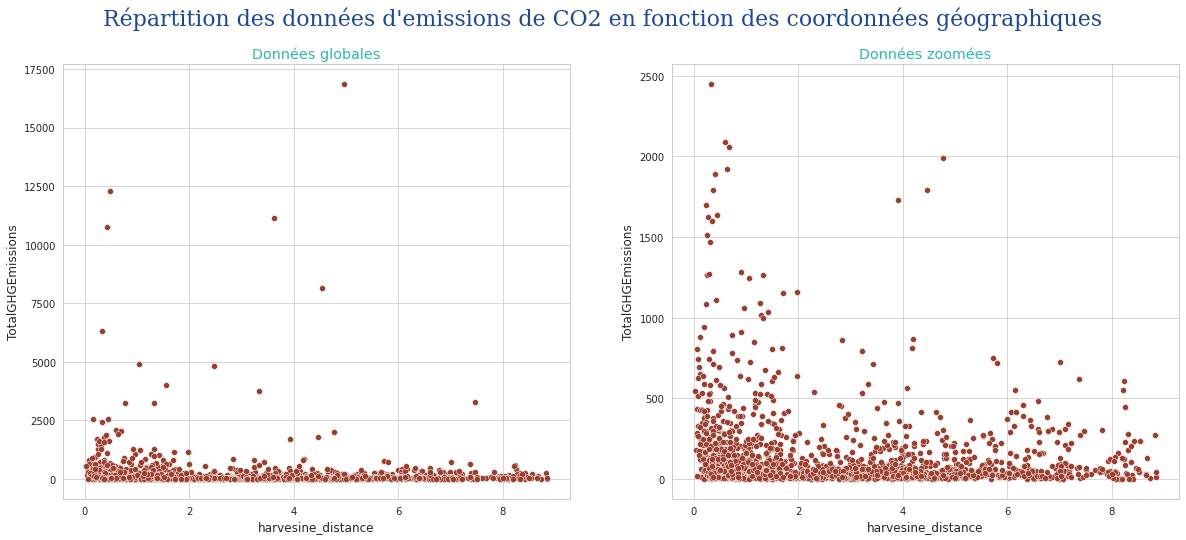

In [67]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.scatterplot(data=data, y="TotalGHGEmissions", x="harvesine_distance", color="#9C3E2D", ax=axes[0])
axes[0].set_title("Données globales", color='#2cb7b0')
sns.scatterplot(data=data[(data['TotalGHGEmissions'] < 2500)], y="TotalGHGEmissions", 
                x="harvesine_distance", color="#9C3E2D", ax=axes[1])
axes[1].set_title("Données zoomées", color='#2cb7b0')
plt.suptitle("Répartition des données d'emissions de CO2 en fonction des coordonnées géographiques", 
             fontdict=font_title, fontsize=22)

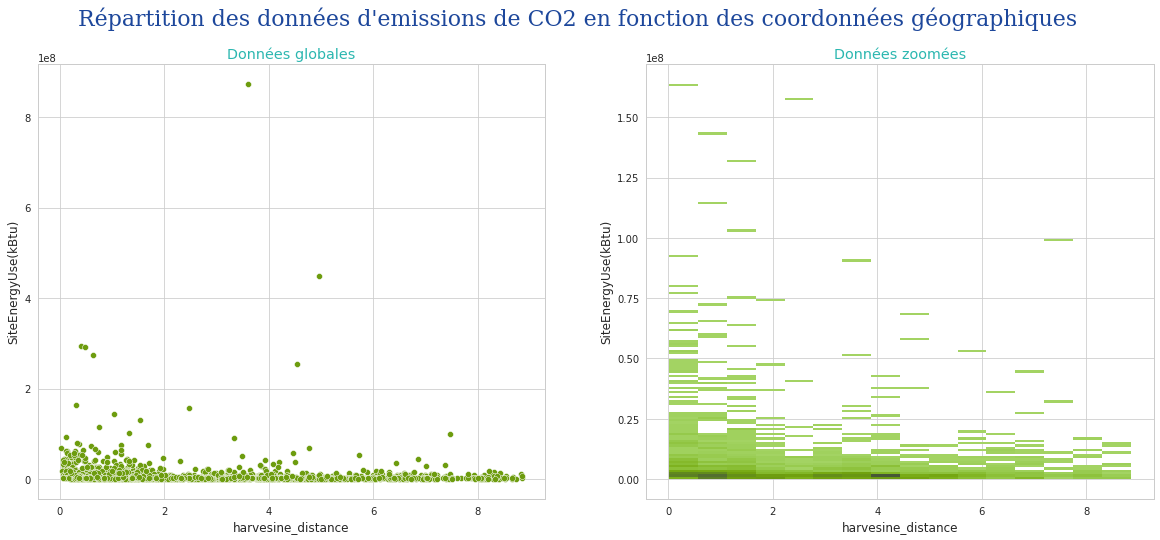

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.scatterplot(data=data, y="SiteEnergyUse(kBtu)", x="harvesine_distance", color="#6D9C0E", ax=axes[0])
axes[0].set_title("Données globales", color='#2cb7b0')
sns.histplot(data=data[(data['SiteEnergyUse(kBtu)'] < 2*10**8)], y="SiteEnergyUse(kBtu)", 
                x="harvesine_distance", color="#6D9C0E", ax=axes[1])
axes[1].set_title("Données zoomées", color='#2cb7b0')
plt.suptitle("Répartition des données d'emissions de CO2 en fonction des coordonnées géographiques", 
             fontdict=font_title, fontsize=22)
plt.show()

### En regardant ces projections, il semble que les coordonnées géographiques (donc les adresses des bâtiments) puissent avoir un impact sur les consommations d'égergie et rejets de CO2.

### D'autre part, la latitude et la longitude étant 2 variables fortement corrélées dans notre jeu de données, nous allons supprimer ces 2 colonnes pour conserver uniquement ce point de coordonnée unique Harvesine .

# 3. Dernières étapes de nettoyage

#### Vérifions la variable ComplianceStatus qui représente la conformité des données relevées :

In [69]:
data['ComplianceStatus'].unique()

array(['Compliant', 'Error - Correct Default Data', 'Missing Data'],
      dtype=object)

In [70]:
print("Nombre de ligne identifiées comme non conforme : {}.".format(data[data['ComplianceStatus'] != "Compliant"].shape[0]))

Nombre de ligne identifiées comme non conforme : 97.


In [71]:
data = data[data['ComplianceStatus'] == "Compliant"]

### Nous allons ensuite supprimer les variables DefaultData, ComplianceStatus, TaxParcelIdentificationNumber, CouncilDistrictCode, City

In [72]:
data = data.drop(['DefaultData','ComplianceStatus', 'City',
                  'TaxParcelIdentificationNumber','CouncilDistrictCode'], axis=1)

# 4. Projection des établissements sur la carte de Seattle

In [73]:
import folium
import folium.plugins

seattle_map = folium.Map(location=[seattle_lat, seattle_lon], zoom_start=11)

#Clusters
marker_cluster = folium.plugins.MarkerCluster().add_to(seattle_map)
for lat, lng, in zip(data.Latitude, data.Longitude):
    folium.Marker(location=[lat, lng]).add_to(marker_cluster)

seattle_map

### Et pour finir, nous supprimons les variables Latitude et Longitude puis nous exportons le fichier cleané pour les modélisations qui seront effectuées dans un second Notebook

In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1556 entries, 256 to 6437
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   OSEBuildingID              1556 non-null   int64  
 1   BuildingType               1556 non-null   object 
 2   PrimaryPropertyType        1556 non-null   object 
 3   PropertyName               1556 non-null   object 
 4   Address                    1556 non-null   object 
 5   State                      1556 non-null   object 
 6   ZipCode                    1556 non-null   float64
 7   Neighborhood               1556 non-null   object 
 8   Latitude                   1556 non-null   float64
 9   Longitude                  1556 non-null   float64
 10  NumberofBuildings          1556 non-null   float64
 11  NumberofFloors             1556 non-null   float64
 12  PropertyGFATotal           1556 non-null   int64  
 13  ListOfAllPropertyUseTypes  1556 non-null   obj

In [75]:
data = data.drop(['Latitude','Longitude'], axis=1)
data.set_index("OSEBuildingID").to_csv("building-energy-cleaned.csv")